# Introduction

This notebook tackles the [**Playground Series – Season 5, Episode 10: Predicting Road Accident Risk**](https://www.kaggle.com/competitions/playground-series-s5e10), a competition focused on a critical real-world problem: predicting the likelihood of road accidents. The goal is to develop a regression model that can accurately estimate accident\_risk based on a variety of road conditions, environmental factors, and historical data.

### Our Approach

To achieve this, we will follow a structured machine learning workflow:

1.  **Exploratory Data Analysis (EDA):** We will begin by conducting a deep dive into the dataset to understand its structure, identify patterns, and uncover relationships between features and the target variable. This includes analyzing feature distributions, correlations, and data quality.
    
2.  **Data Preprocessing & Feature Engineering:** Based on insights from the EDA, we will clean the data (e.g., handle duplicates) and engineer new features to enhance the predictive power of our model. This will involve encoding categorical variables and creating interaction terms.
    
3.  **Model Development:** We will build and train a robust predictive model. Given the tabular nature of the data, we will likely focus on gradient boosting models like LightGBM or XGBoost, which are known for their high performance in similar competitions.
    
4.  **Submission:** Finally, we will use our trained model to make predictions on the test set and generate a submission.csv file in the required format.
    

### Initial Findings from EDA

Our preliminary analysis has already revealed several key characteristics of the dataset:

*   **High-Quality Data:** The training and test sets are well-structured and contain **no missing values**, which simplifies the preprocessing stage.
    
*   **Consistent Distributions:** The feature distributions between the training and test sets are remarkably similar, suggesting that a model trained on this data should generalize well.
    
*   **Key Predictors:** curvature and speed\_limit have emerged as the features with the strongest positive correlation to accident\_risk.
    
*   **Potential Data Leakage:** The num\_reported\_accidents feature shows a correlation with the target and will be handled with care to avoid data leakage.
    

Let's begin by loading the necessary libraries and exploring the data.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Training Dataset EDA](#Training-Dataset-EDA)
5. [Test Dataset EDA](#Test-Dataset-EDA)
6. [Examine Original Dataset](#Examine-Original-Dataset)
7. [Original Dataset EDA](#Original-Dataset-EDA)
8. [Dataset Comparison Report](#Dataset-Comparison-Report)
9. [Feature Engineering](#Feature-Engineering)
10. [Model Training](#Model-Training)
11. [Prepare Submission](#Prepare-Submission)

# Data Loading and Overview

In [1]:
!pip uninstall -y sweetviz
!pip install sweetviz

Found existing installation: sweetviz 2.3.1
Uninstalling sweetviz-2.3.1:
  Successfully uninstalled sweetviz-2.3.1
  Using cached sweetviz-2.3.1-py3-none-any.whl.metadata (24 kB)
Using cached sweetviz-2.3.1-py3-none-any.whl (15.1 MB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip -q install --upgrade ydata_profiling sweetviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# --- Standard library
import os
import sys
import math
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time
from typing import Iterable
from IPython.display import display, Markdown, IFrame

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)
import scipy.stats as st
from scipy.stats import uniform, randint, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ydata_profiling import ProfileReport
import sweetviz as sv
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn import set_config
set_config(transform_output="pandas")
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm
import xgboost as xgb

# --- Notebook settings
warnings.filterwarnings("ignore")

# Suppress XGBoost warnings about mismatched devices and tree methods.
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

%matplotlib inline

In [6]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [7]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook(max_columns = None, max_rows = None)    

In [8]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgbm_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgbm.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", "gpu_platform_id": platform_id, "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [9]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [10]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e10') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2      0.060           35  daylight   rainy   
1   1     urban          4      0.990           35  daylight   clear   
2   2     rural          4      0.630           70       dim   clear   
3   3   highway          4      0.070           35       dim   rainy   
4   4     rural          1      0.580           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1          0.130  
1                       0          0.350  
2                       2          0.300  
3                       1          0.210  
4                       1          0.560

#### Read the test data and display it

In [11]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0  517754   highway          2      0.340           45     night   clear   
1  517755     urban          3      0.040           45       dim   foggy   
2  517756     urban          2      0.590           35       dim   clear   
3  517757     rural          4      0.950           35  daylight   rainy   
4  517758   highway          2      0.860           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0  
2                       1  
3                       2  
4                       3

#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [12]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

road_type  num_lanes  curvature  speed_limit  lighting weather  \
0     urban          2      0.060           35  daylight   rainy   
1     urban          4      0.990           35  daylight   clear   
2     rural          4      0.630           70       dim   clear   
3   highway          4      0.070           35       dim   rainy   
4     rural          1      0.580           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1          0.130  
1                       0          0.350  
2                       2          0.300  
3                       1          0.210  
4                       1          0.560

In [13]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   highway          2      0.340           45     night   clear   
1     urban          3      0.040           45       dim   foggy   
2     urban          2      0.590           35       dim   clear   
3     rural          4      0.950           35  daylight   rainy   
4   highway          2      0.860           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0  
2                       1  
3                       2  
4                       3

## Exploratory Data Analysis

In [14]:
# eda_summary(training_df)
profile = ProfileReport(training_df, title="Training EDA Report")
profile.to_file("training_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 43.88it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Display the HTML report in an iframe
# Adjust width and height as needed for your display
IFrame(src='training_report.html', width=1000, height=600)

# Sweetviz comparison example
# report = sv.analyze([training_df, "Training Dataset"])
# report.show_html("sweetviz_report.html")

#### Show the statistics and structure of the test data

In [16]:
profile = ProfileReport(test_df, title="Test EDA Report")
profile.to_file("test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Display the HTML report in an iframe
# Adjust width and height as needed for your display
IFrame(src='test_report.html', width=1000, height=600)

# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **accident_risk** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms and guard against outlier‑driven RMSE errors.

In [18]:
TARGET = "accident_risk"
IS_CLASSIFICATION = training_df[TARGET].nunique() <= 10 and training_df[TARGET].dtype != float

In [19]:
def split_columns(df: pd.DataFrame, max_cardinality: int = 30):
    """
    Heuristic split into numeric vs categorical, with a cardinality cap for cats.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    
    # treat low-unique integer columns as categorical (IDs will be filtered later)
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_cardinality:
            cat_cols.append(c)
            num_cols.remove(c)
            
    # drop high-cardinality cats from categorical plotting by default
    low_card_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= max_cardinality]
    
    return num_cols, low_card_cats
    
# short axis label helper
def colname(v):
    return str(v).replace("_", " ").title()

In [20]:
def plot_missingness(df: pd.DataFrame):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if miss.empty:
        print("No missing values.")
        return
        
    plt.figure(figsize = (8, max(2, 0.3 * len(miss))))
    plt.barh(miss.index, miss.values)
    plt.xlabel("Fraction Missing")
    plt.title("Missingness by Column")
    plt.gca().invert_yaxis()
    plt.show()
    
    display(miss.to_frame("missing_frac"))

In [21]:
def plot_numeric_univariate(df: pd.DataFrame, cols: Iterable[str], kde: bool = True):
    for c in cols:
        x = df[c].dropna().to_numpy()
        if x.size == 0:
            continue

        # ECDF (robust view of distribution)
        xs = np.sort(x)
        ys = np.arange(1, xs.size + 1) / xs.size
        plt.figure(figsize=(7, 4))
        plt.plot(xs, ys)
        plt.xlabel(colname(c)); plt.ylabel("ECDF")
        plt.title(f"{c} – Empirical CDF")
        plt.show()

        # Smooth density (KDE) if supported and enough data
        if kde and xs.size >= 50:
            try:
                from scipy.stats import gaussian_kde
                grid = np.linspace(xs.min(), xs.max(), 256)
                dens = gaussian_kde(xs)(grid)
                plt.figure(figsize=(7, 4))
                plt.plot(grid, dens)
                plt.xlabel(colname(c)); plt.ylabel("Density")
                plt.title(f"{c} – Density (KDE)")
                plt.show()
            except Exception as e:
                # skip quietly if scipy not available
                pass

In [22]:
def plot_categorical_univariate(df: pd.DataFrame, cols: Iterable[str], top_n = 20, normalize = False):
    for c in cols:
        vc = df[c].astype("object").value_counts(dropna=False)
        if vc.empty:
            continue
            
        vc = vc.head(top_n)
        plt.figure(figsize=(8, max(2, 0.35 * len(vc))))
        plt.barh(vc.index.astype(str), vc.values if not normalize else (vc.values / vc.sum()))
        plt.gca().invert_yaxis()
        plt.xlabel("Count" if not normalize else "Proportion")
        plt.title(f"{c} – Top {len(vc)} Categories")
        plt.show()

In [23]:
def collapse_rare_categories(s: pd.Series, min_count: int = 50) -> pd.Series:
    vc = s.value_counts()
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other="__OTHER__")

In [24]:
def categorical_vs_target_classification(df: pd.DataFrame, feature, target, min_count = 50, top_n = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    grp = d.groupby(feature)
    counts = grp.size().sort_values(ascending=False).head(top_n)
    cats = counts.index

    rate = grp[target].mean().reindex(cats)

    # counts
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], counts.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(f"{feature} – Top {len(cats)} Counts")
    plt.show()

    # target rates
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], rate.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}"); plt.title(f"{feature} – Target Rate (Top {len(cats)})")
    plt.show()

In [25]:
def numeric_vs_target_regression(df: pd.DataFrame, feature:str, target:str = TARGET, n_bins:int = 20):
    # guardrails
    s = df[feature]
    if pd.api.types.is_bool_dtype(s) or s.nunique(dropna = True) < 2:
        return  # treat bools as categorical elsewhere; skip constants

    d = df[[feature, target]].dropna()
    if d.empty:
        return

    # Use quantile bins unless the feature has very few unique values
    if d[feature].nunique() <= n_bins:
        # group by the actual values (e.g., speed_limit with few discrete values)
        gb = d.groupby(feature, sort = True)[target]
        centers = gb.mean().index.to_numpy(dtype = float)  # numeric categories
    else:
        q = pd.qcut(
            d[feature],
            q=min(n_bins, d[feature].nunique()),
            duplicates="drop"
        )
        gb = d.groupby(q, observed=True)[target]
        idx = gb.mean().index  # IntervalIndex
        # bin centers
        centers = getattr(idx, "mid", np.array([(iv.left + iv.right) / 2.0 for iv in idx]))

    means = gb.mean().to_numpy()
    stds  = gb.std(ddof = 0).to_numpy()

    # mean line
    plt.figure(figsize = (7, 4))
    plt.plot(centers, means)
    plt.xlabel(colname(feature)); 
    plt.ylabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} by Bin")
    plt.show()

    # std line
    plt.figure(figsize = (7, 4))
    plt.plot(centers, stds)
    plt.xlabel(colname(feature)); 
    plt.ylabel(f"Std({target})")
    plt.title(f"{feature} – Target Std by Bin")
    plt.show()

In [26]:
def categorical_vs_target_regression(df: pd.DataFrame, feature:str, target:str = TARGET, min_count:int = 50, top_n:int = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count = min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    stats = d.groupby(feature)[target].agg(["count", "mean"]).sort_values("count", ascending = False).head(top_n)

    plt.figure(figsize=(8, max(2, 0.35 * len(stats))))
    plt.barh(stats.index.astype(str), stats["mean"].values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} (Top {len(stats)})")
    plt.show()

    plt.figure(figsize=(8, max(2, 0.35 * len(stats))))
    plt.barh(stats.index.astype(str), stats["count"].values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count")
    plt.title(f"{feature} – Count (Top {len(stats)})")
    plt.show()

In [27]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y)
    chi2 = chi2_contingency(tbl, correction = False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    v = np.sqrt(chi2 / (n * (min(r, k) - 1)))
    return float(v)

def categorical_associations(df: pd.DataFrame, cats: Iterable[str]):
    cats = [c for c in cats if df[c].notna().any()]
    out = pd.DataFrame(index = cats, columns = cats, dtype = float)
    for i, c1 in enumerate(cats):
        for c2 in cats[i:]:
            v = cramers_v(df[c1].astype("object"), df[c2].astype("object"))
            out.loc[c1, c2] = out.loc[c2, c1] = v
    return out

In [28]:
def has_target(df: pd.DataFrame, target:str):
    return target is not None and target in df.columns

In [29]:
def check_leakage(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Target bounds and mass at the edges
    t = df["accident_risk"].dropna().to_numpy()
    print(f"min={t.min():.4f}, max={t.max():.4f}")
    print(f"mass at 0: {(t==0).mean():.3%}, mass at 1: {(t==1).mean():.3%}")

    # Simple leakage probe (e.g., counts that trivially drive risk)
    suspects = ["num_reported_accidents"]
    for c in suspects:
        if c in df.columns:
            s = df[[c, "accident_risk"]].dropna()
            rho = s[c].corr(s["accident_risk"])
            print(f"{c}: Pearson r = {rho:.3f} (check this column carefully)")

In [30]:
def plot_target_by_category(df: pd.DataFrame, cat:str, target:str = TARGET, top_n:int = 20, min_count:int = 100):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return

    d = df[[cat, target]].dropna()
    vc = d[cat].astype("object").value_counts()
    keep = vc[vc >= min_count].head(top_n).index
    d = d[d[cat].isin(keep)]
    g = d.groupby(cat)[target].agg(["count","mean","std"])
    se = g["std"] / (g["count"].clip(lower = 1) ** 0.5)  # standard error

    # mean line with error bars (horizontal layout)
    plt.figure(figsize=(8, max(2, 0.35 * len(g))))
    idx = g.index.astype(str)
    plt.errorbar(g["mean"].values, np.arange(len(g)), xerr = 1.96 * se.values, fmt = "o")
    plt.yticks(np.arange(len(g)), idx)
    plt.xlabel(f"Mean {target} (±95% CI)")
    plt.title(f"{cat} → {target}")
    plt.gca().invert_yaxis()
    plt.show()

In [31]:
def binned_mean_std(df: pd.DataFrame, xcol:str, target:str = TARGET, q:int = 20):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[xcol, target]].dropna().sort_values(xcol)

    # skip booleans or constant columns
    if pd.api.types.is_bool_dtype(d[xcol]) or d[xcol].nunique() < 2:
        return
        
    # quantile bins
    bins = pd.qcut(d[xcol], q=min(q, d[xcol].nunique()), duplicates = "drop")
    g = d.groupby(bins)[target].agg(["mean", "std", "count"])
    
    idx = g.index  # IntervalIndex
    try:
        centers = idx.mid.to_numpy()
    except AttributeError:
        # fallback for very old pandas
        centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])

    plt.figure(figsize=(7, 4))
    plt.plot(centers, g["mean"].values)
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}"); 
    plt.title(f"{xcol} → mean({target})")
    plt.show()
    
    plt.figure(figsize=(7, 4))
    plt.plot(centers, g["std"].values)
    plt.xlabel(xcol); 
    plt.ylabel(f"Std({target})"); 
    plt.title(f"{xcol} → std({target})")
    plt.show()

In [32]:
def numeric_by_category_trend(df: pd.DataFrame, xcol:str, cat:str, target:str = TARGET, q:int = 15, min_count:int = 2000):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Keep frequent categories to reduce noise
    keep = df[cat].value_counts()
    keep = keep[keep >= min_count].index
    for k in keep:
        d = df[df[cat] == k][[xcol, target]].dropna()
        if d.empty or d[xcol].nunique() <2 : 
            continue
            
        bins = pd.qcut(d[xcol], q = min(q, d[xcol].nunique()), duplicates = "drop")
        m = d.groupby(bins)[target].mean()

        idx = m.index
        try:
            centers = idx.mid.to_numphy()
        except AttributeError:
            # fallback for very old pandas
            centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])
            
    plt.plot(centers, m.values, label = str(k))
    plt.title(f"{xcol} → mean({target}) by {cat}")
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}")
    plt.legend(loc="best")
    plt.show()

In [33]:
def cat_cat_heatmap(df: pd.DataFrame, cat1:str, cat2:str, target:str = TARGET, min_count:int = 500):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[cat1, cat2, target]].dropna()
    g = d.groupby([cat1, cat2])[target].agg(["mean", "count"]).reset_index()
    g = g[g["count"] >= min_count]
    if g.empty:
        print(f"[info] No {cat1}×{cat2} cells with count >= {min_count}.")
        return

    # Normalize labels ONCE to consistent strings
    s1 = g[cat1].astype("string").fillna("<NA>").astype(str)
    s2 = g[cat2].astype("string").fillna("<NA>").astype(str)

    # Stable ordering (by label) or by frequency if preferred
    rows, r_codes = np.unique(s1, return_inverse = True)
    cols, c_codes = np.unique(s2, return_inverse = True)

    A = np.full((len(rows), len(cols)), np.nan, dtype = float)
    A[r_codes, c_codes] = g["mean"].to_numpy()

    plt.figure(figsize=(1.2 * len(cols) + 2, 1.2 * len(rows) + 2))
    im = plt.imshow(A, aspect = "auto", origin = "upper")
    cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04, label = f"Mean {target}")
    plt.xticks(np.arange(len(cols)), cols, rotation = 45, ha = "right")
    plt.yticks(np.arange(len(rows)), rows)
    plt.title(f"{cat1} × {cat2} → mean({target})")
    plt.tight_layout()
    plt.show()

In [34]:
def numeric_numeric_hex(df: pd.DataFrame, x:str, y:str, target:str = TARGET, gridsize:int = 50):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[x, y, target]].dropna()
    plt.figure(figsize = (7, 5))
    hb = plt.hexbin(d[x].to_numpy(), d[y].to_numpy(), C=d[target].to_numpy(),
                    gridsize = gridsize, reduce_C_function = np.mean)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} × {y} → mean({target})")
    cb = plt.colorbar(hb)
    cb.set_label(f"Mean {target}")
    plt.show()

In [35]:
def time_of_day_vs_risk_line(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Time_of_day has discrete labels ("morning","afternoon","evening")
    order = ["morning", "afternoon", "evening"]
    d = df[["time_of_day","accident_risk"]].dropna()
    d = d[d["time_of_day"].isin(order)]
    g = d.groupby("time_of_day")["accident_risk"].mean().reindex(order)

    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(g)), g.values)
    plt.xticks(np.arange(len(g)), g.index, rotation = 0)
    plt.xlabel("time_of_day"); 
    plt.ylabel("Mean accident_risk"); 
    plt.title("Daily pattern")
    
    plt.show()

In [36]:
# Feature signal ranking without modeling
def show_feature_signal_ranking(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Spearman for numeric; ANOVA-style effect for categoricals
    num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target]

    scores = []
    for c in num_cols:
        s = df[[c, target]].dropna()
        if s.empty: continue
        rho, p = st.spearmanr(s[c], s[target])
        scores.append((c, float(rho)))
    scores = sorted(scores, key = lambda x: -abs(x[1]))
    print("Top numeric (|Spearman|):", scores[:10])

    cat_cols = [c for c in df.columns if c not in num_cols + [target]]
    effects = []
    for c in cat_cols:
        g = df.groupby(c, observed = True)[target].mean()
        if g.size >= 2:
            rng = float(g.max() - g.min())
            effects.append((c, rng, int(df[c].nunique())))
            
    effects = sorted(effects, key = lambda x: -x[1])
    print("Top categorical (range of mean risk):", effects[:10])

In [37]:
def plot_pairplot(df: pd.DataFrame, num_features: Iterable[str], target:str = TARGET):
    """
    Generates a pair plot for numerical features, colored by the target variable.
    """
    # Increase the 'height' parameter to make the overall plot larger.
    # A good starting point is around 3 to 5.
    sns.pairplot(df[num_features + [target]], hue=target, palette = 'viridis', height = 6)

    plt.suptitle('Pair Plot of Numerical Features', y=1.02)
    plt.show()
    
def plot_boxplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target: str = TARGET, n_cols: int = 3):
    """
    Generates box plots for each categorical feature against the target variable
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.boxplot(x=feature, y=target, data=df, palette='viridis', ax = ax)
        ax.set_title(f'Box Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()

def plot_violinplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target:str = TARGET, n_cols: int = 3):
    """
    Generates violin plots for each categorical feature against the target variable.
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.violinplot(x=feature, y=target, data = df, palette = 'viridis', ax = ax)
        ax.set_title(f'Violin Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()        

In [38]:
def is_discrete_numeric(s: pd.Series, max_unique:int = 20):
    return pd.api.types.is_numeric_dtype(s) and s.nunique(dropna = True) <= max_unique

def top_numeric_by_spearman(df: pd.DataFrame, num_cols: Iterable[str], target, k = 6):
    import scipy.stats as st
    scores = []
    for c in num_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        # skip all-constant / all-equal
        if d[c].nunique() < 2: 
            continue
            
        rho, _ = st.spearmanr(d[c], d[target])
        if np.isfinite(rho):
            scores.append((c, abs(float(rho))))
            
    scores.sort(key=lambda x: -x[1])
    return [c for c,_ in scores[:k]]

def top_categorical_by_range(df: pd.DataFrame, cat_cols: Iterable[str], target:str = TARGET, min_count:int = 200, k:int = 6):
    effects = []
    for c in cat_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        vc = d[c].value_counts()
        keep = set(vc[vc >= min_count].index)
        if not keep:
            continue
            
        m = d[d[c].isin(keep)].groupby(c)[target].mean()
        if m.size >= 2:
            effects.append((c, float(m.max() - m.min())))
            
    effects.sort(key=lambda x: -x[1])
    return [c for c,_ in effects[:k]]

In [39]:
def run_eda(df: pd.DataFrame, target: str, max_cat_card: int = 30,
            heavy_sample: int = 150_000, num_count: int = 10, cat_count = 10):
    """
    Compact EDA runner for mixed tabular data.
    - Uses new target-aware visuals when target is present.
    - Skips safely on test sets (no target).
    - Limits heavy plots to top-signal features.
    - Optionally downsamples for hexbin/heatmaps.
    """
    # Separate a version without target (works if target absent)
    df_wo_target = df.drop(columns = [target], errors = "ignore") if target else df

    # Split columns
    num_cols, cat_cols = split_columns(df_wo_target, max_cardinality = max_cat_card)
    
    # Treat booleans as categorical for plotting
    bool_cols = [c for c in df_wo_target.columns if pd.api.types.is_bool_dtype(df_wo_target[c])]
    cat_cols = sorted(set(cat_cols).union(bool_cols))

    # Target-aware (only if target present)
    if not has_target(df, target):
        print("Target not present → skipping target-aware plots.")
        return

    y = df[target]
    is_regression = pd.api.types.is_numeric_dtype(y) and y.nunique(dropna = True) > 20

    # Choose top features to keep plots readable and fast
    if is_regression:
        top_nums = top_numeric_by_spearman(df, [c for c in num_cols if c != target], target, k = num_count) or num_cols[:num_count]
        top_cats = top_categorical_by_range(df, cat_cols, target, min_count = 200, k = cat_count) or cat_cols[:cat_count]

        # Pair plots
        display(Markdown("### Pair Plots"))
        plot_pairplot(df, top_nums, target)

        # Box plots
        display(Markdown("### Box Plots"))
        plot_boxplots_grid(df, top_cats, target)

        # Violin plots
        display(Markdown("### Violin Plots"))
        plot_violinplots_grid(df, top_cats, target)

        # Interactions (small set)
        # numeric × categorical (trend by category)
        if top_nums and top_cats:
            display(Markdown("### Numeric × Categorical (Trend By Category)"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 15, min_count = 3000)

        # categorical × categorical (heatmap)
        if len(top_cats) >= 2:
            display(Markdown("### Categorical × Categorical (Heatmap)"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1000)

        # numeric × numeric (hexbin target mean)
        if len(top_nums) >= 2:
            display(Markdown("### Numeric × Numeric (Hexbin Target Mean)"))
            d_hex = df
            if heavy_sample is not None and len(df) > heavy_sample:
                d_hex = df.sample(heavy_sample, random_state = seed)
            numeric_numeric_hex(d_hex, top_nums[0], top_nums[1], target = target, gridsize = 50)

    else:
        # Classification-style (few unique target values)
        top_nums = [c for c in num_cols if c != target][:6]
        top_cats = cat_cols[:6]

        for c in top_nums:
            try:
                numeric_vs_target_classification(df, c, target)
            except Exception as e:
                print(f"[warn] numeric(classif) plot failed for {c}: {e}")

        for c in top_cats:
            try:
                categorical_vs_target_classification(df, c, target, min_count = 100, top_n = 20)
            except Exception as e:
                print(f"[warn] categorical(classif) plot failed for {c}: {e}")

        # A couple of interactions
        if len(top_nums) and len(top_cats):
            display(Markdown("### Numeric x Category Trend"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 12, min_count = 3000)
        if len(top_cats) >= 2:
            display(Markdown("### Category x Category Trend"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1500)

    # Display time of day vs risk line
    display(Markdown("### Time of Day vs Risk Line"))
    time_of_day_vs_risk_line(df)

    display(Markdown("### Feature Signal Ranking"))
    show_feature_signal_ranking(df)


## Training Dataset EDA

### Pair Plots

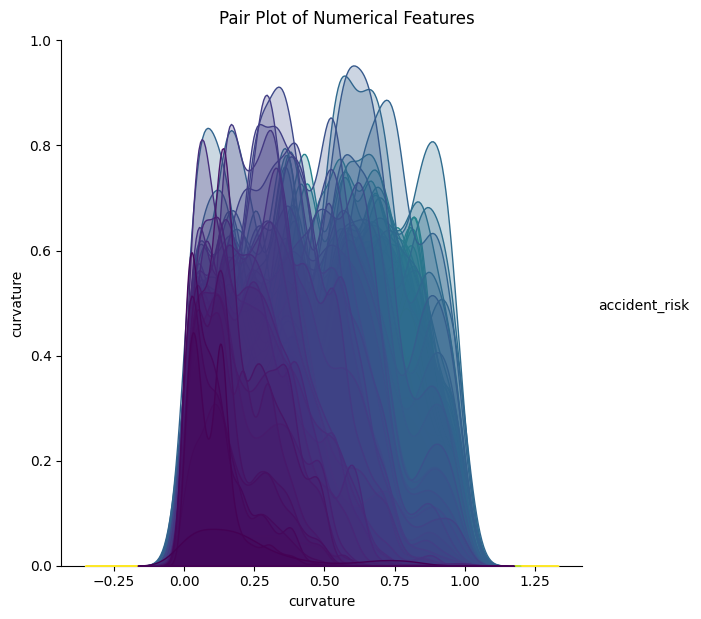

### Box Plots

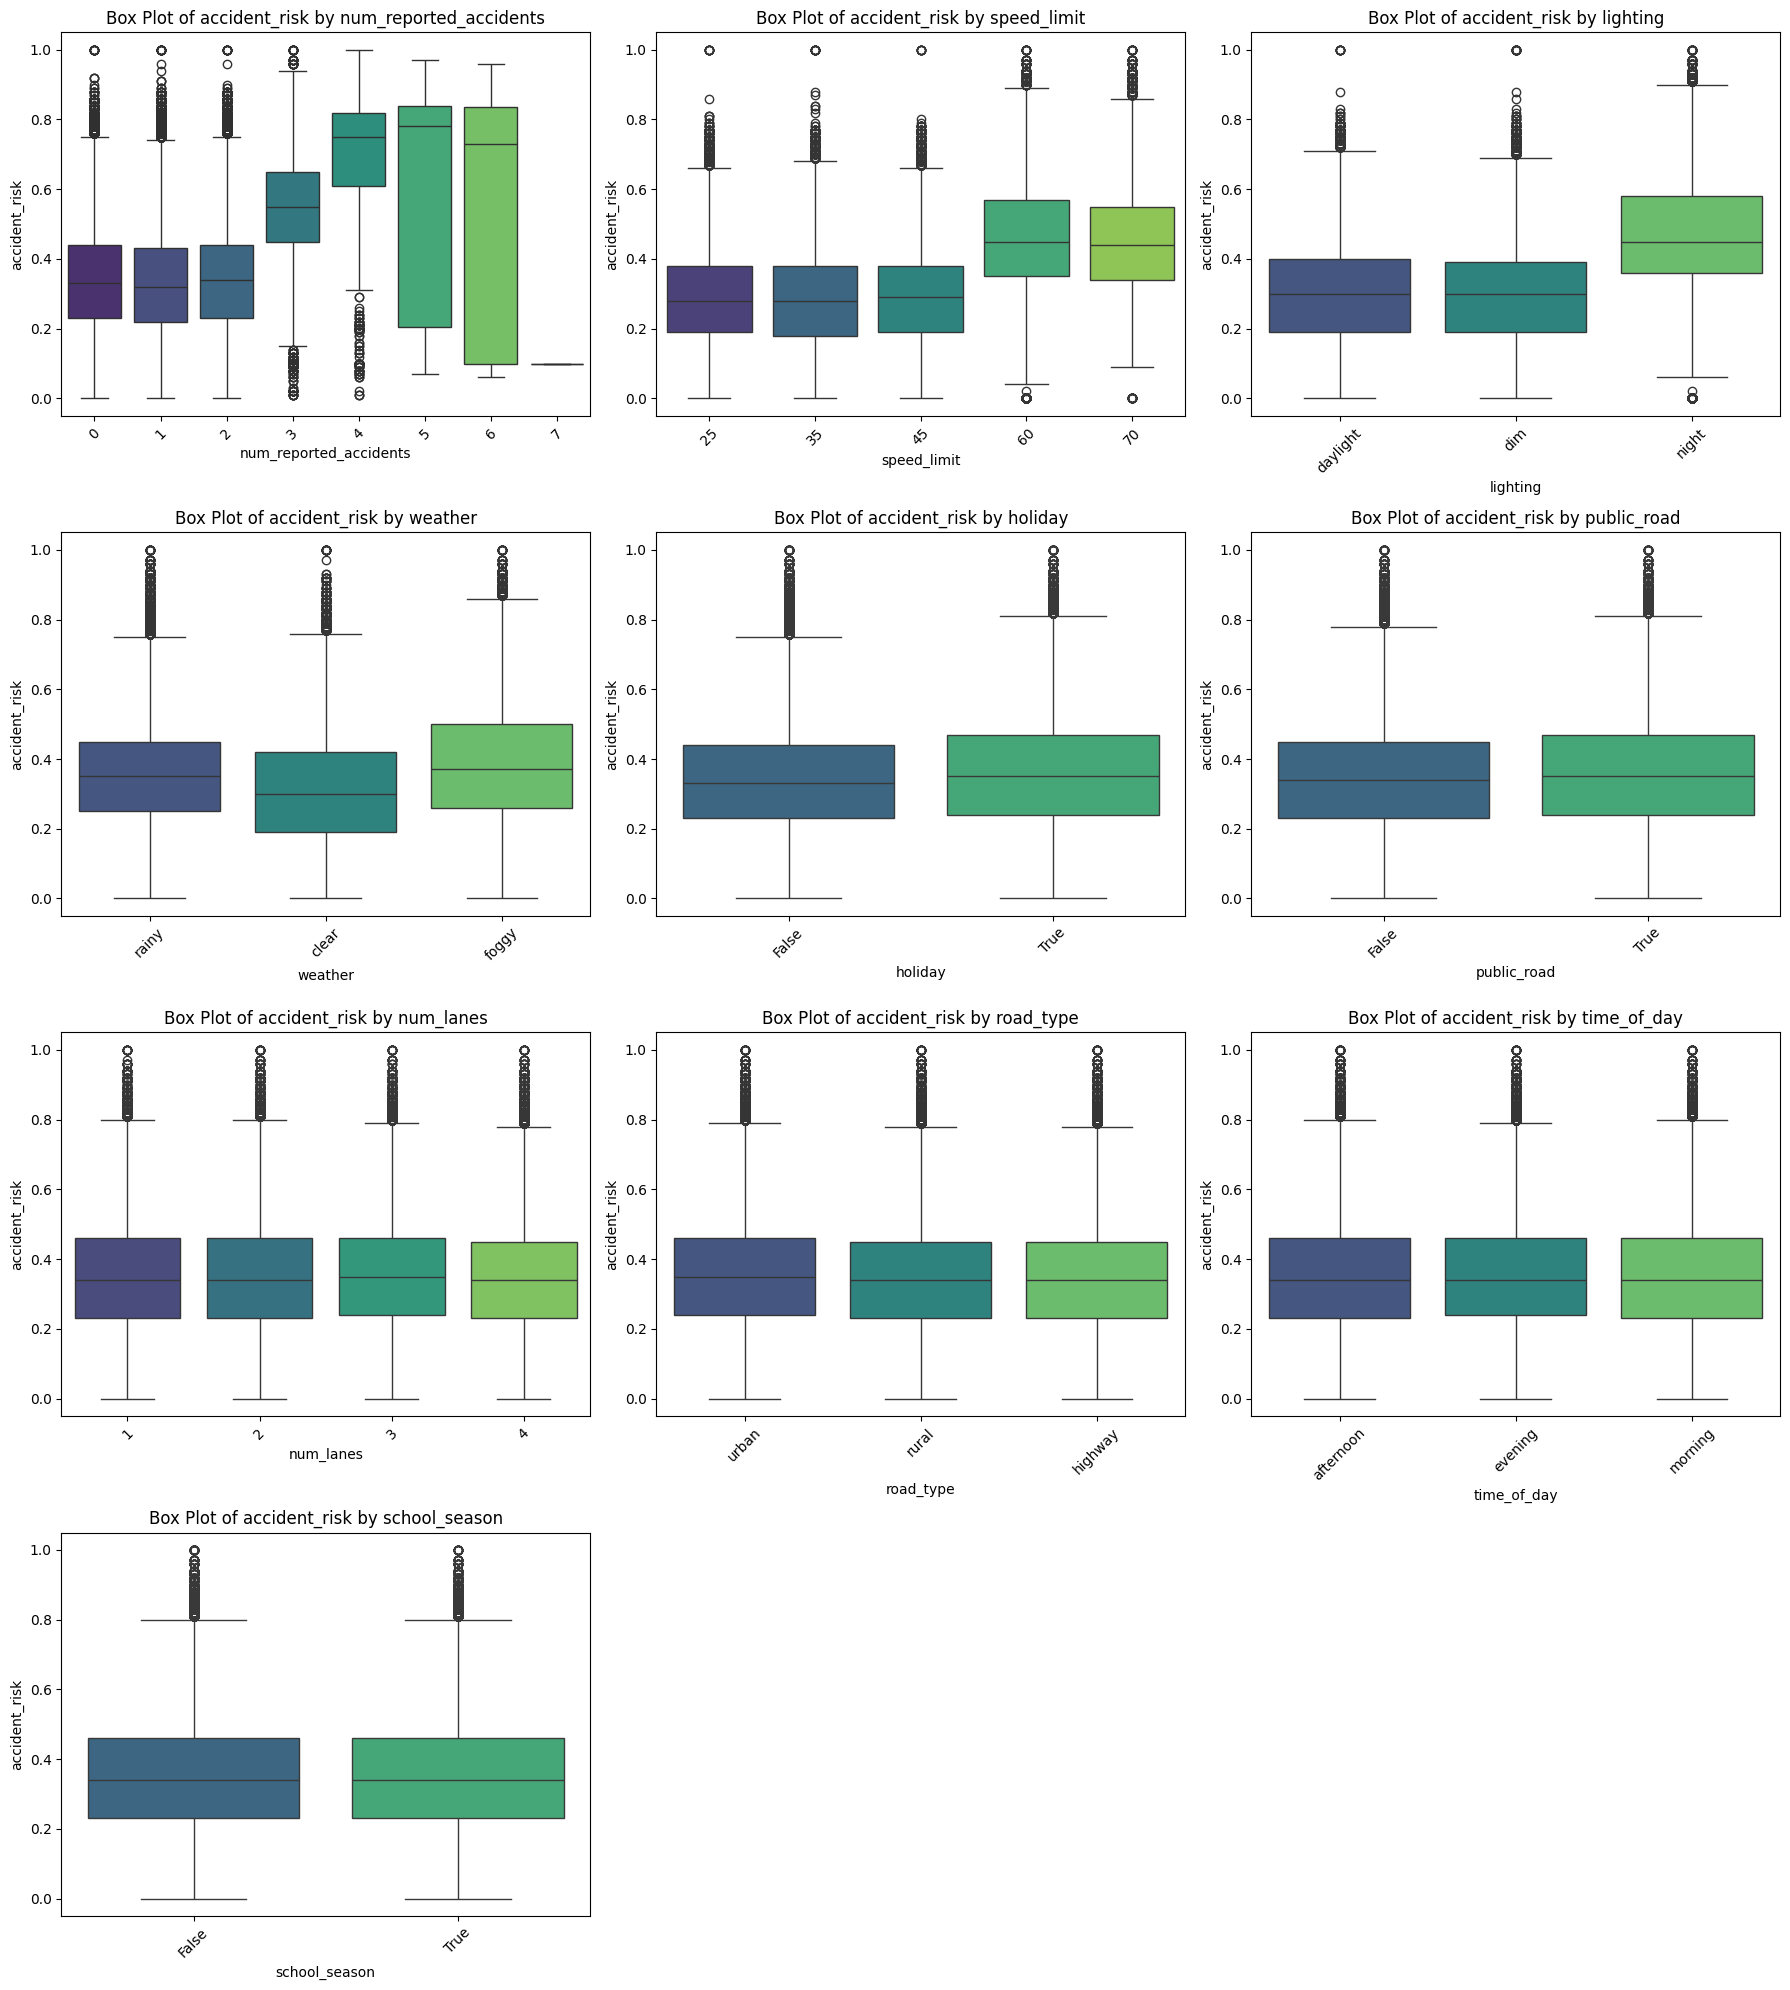

### Violin Plots

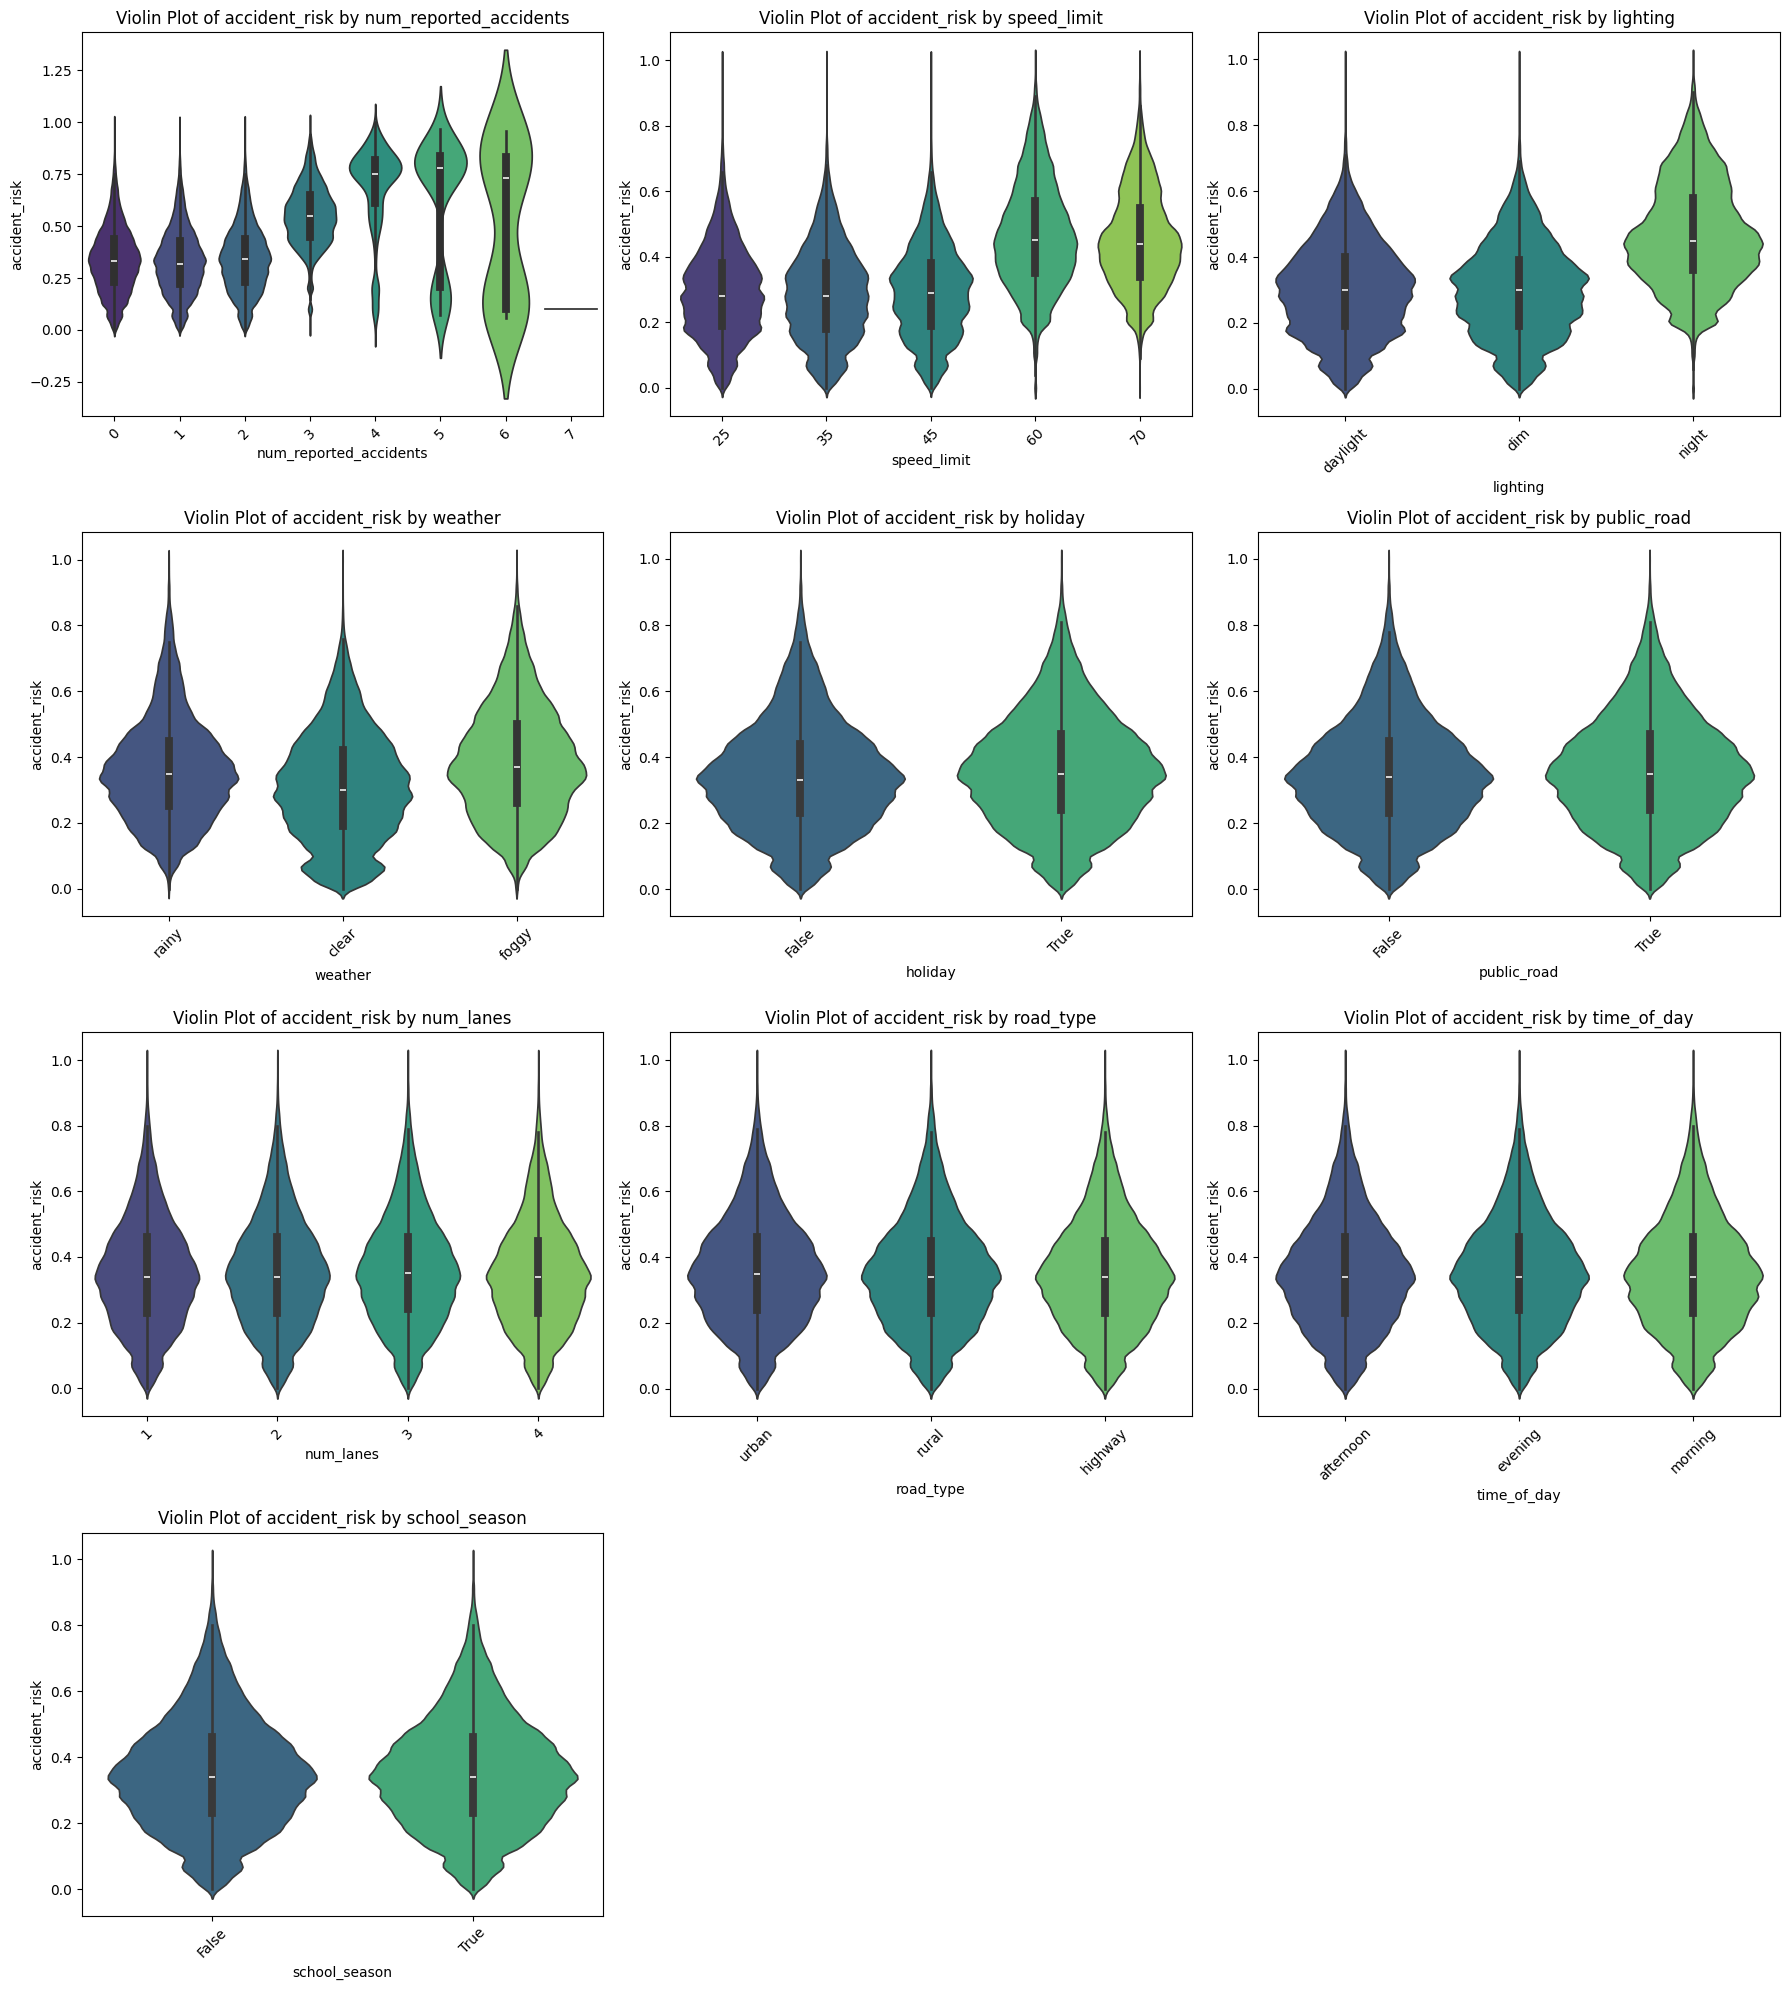

### Numeric × Categorical (Trend By Category)

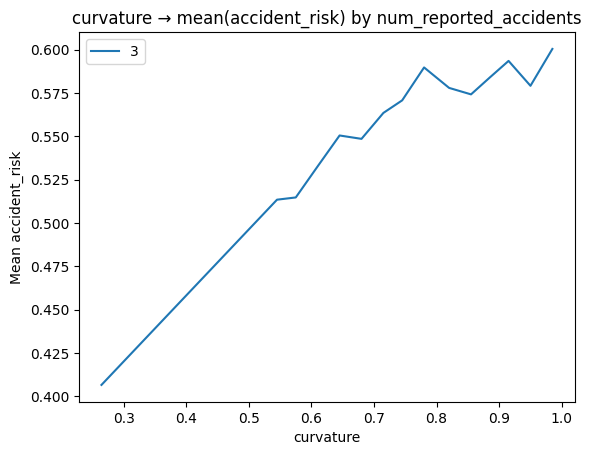

### Categorical × Categorical (Heatmap)

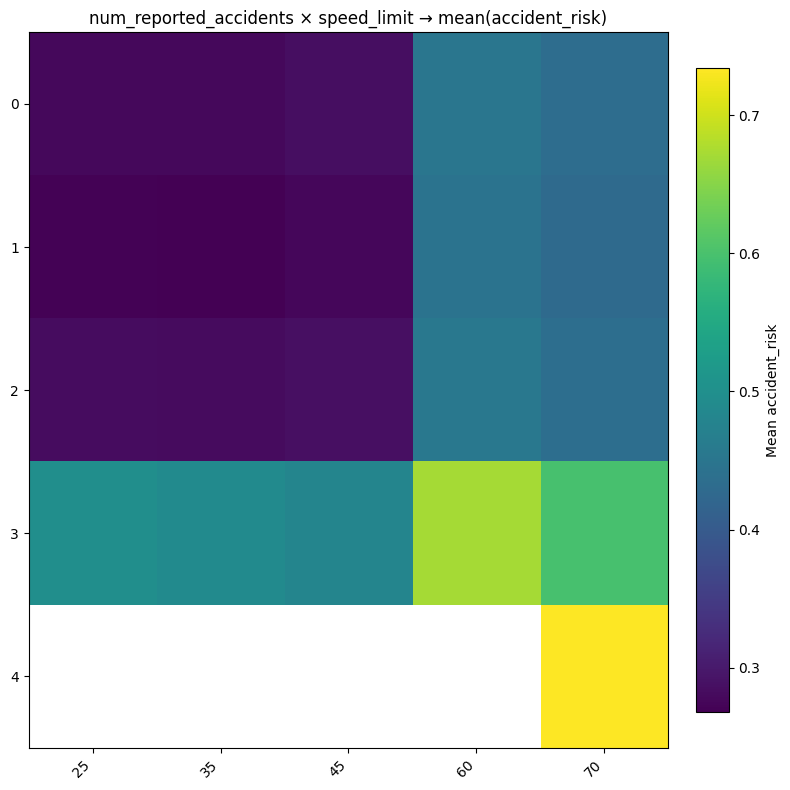

### Time of Day vs Risk Line

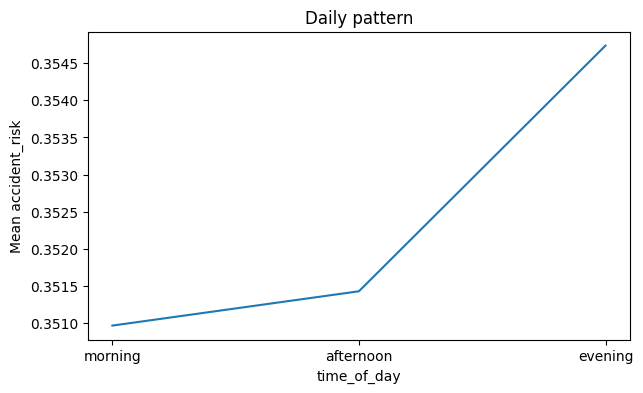

### Feature Signal Ranking

Top numeric (|Spearman|): [('curvature', 0.5467742572078576), ('speed_limit', 0.40914437276337084), ('num_reported_accidents', 0.15426290391245698), ('num_lanes', -0.007230978036206295)]
Top categorical (range of mean risk): [('lighting', 0.1703579791069305, 3), ('weather', 0.07624463499104406, 3), ('holiday', 0.017017868121310176, 2), ('public_road', 0.010328730695673638, 2), ('road_type', 0.007721712947188375, 3), ('time_of_day', 0.003769930463624338, 3), ('school_season', 0.0003251453185004194, 2), ('road_signs_present', 0.00020947831427381436, 2)]


In [40]:
run_eda(training_df, target = TARGET, max_cat_card = 30)

## Test Dataset EDA

In [41]:
run_eda(test_df, target = TARGET, max_cat_card = 30)

Target not present → skipping target-aware plots.


## Examine Original Dataset

In [42]:
ORIGINAL_DIR = Path("/kaggle/input/simulated-roads-accident-data") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'synthetic_road_accidents_100k.csv')
original_df.head()

road_type  num_lanes  curvature  speed_limit lighting weather  \
0     rural          2      0.290           70    night   rainy   
1   highway          1      0.340           25      dim   clear   
2     rural          2      0.760           70    night   foggy   
3     rural          3      0.370           70    night   foggy   
4   highway          3      0.390           45      dim   rainy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True     evening    False          False   
1               False        False     morning    False          False   
2                True        False     evening     True           True   
3                True        False     morning    False           True   
4               False         True     morning    False          False   

   num_reported_accidents  accident_risk  
0                       1          0.640  
1                       3          0.270  
2                       1          0.760  
3                       0          0.600  
4                       0          0.170

## Original Dataset EDA

### Pair Plots

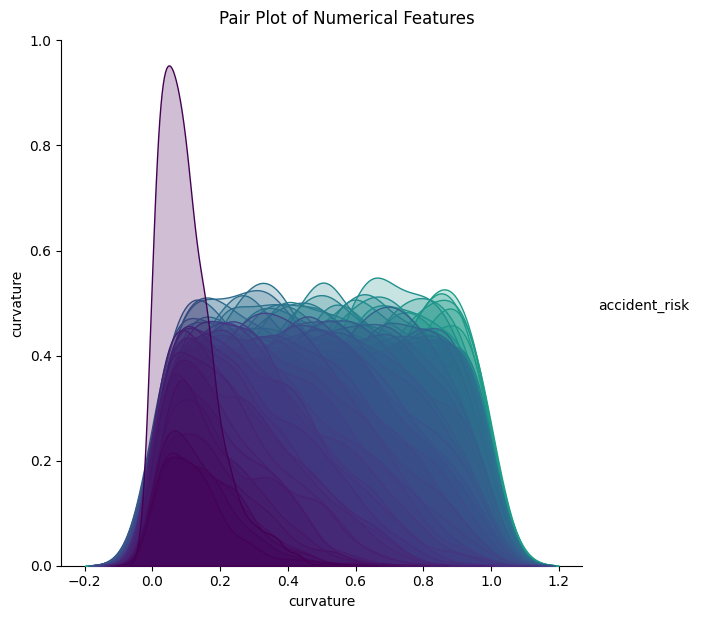

### Box Plots

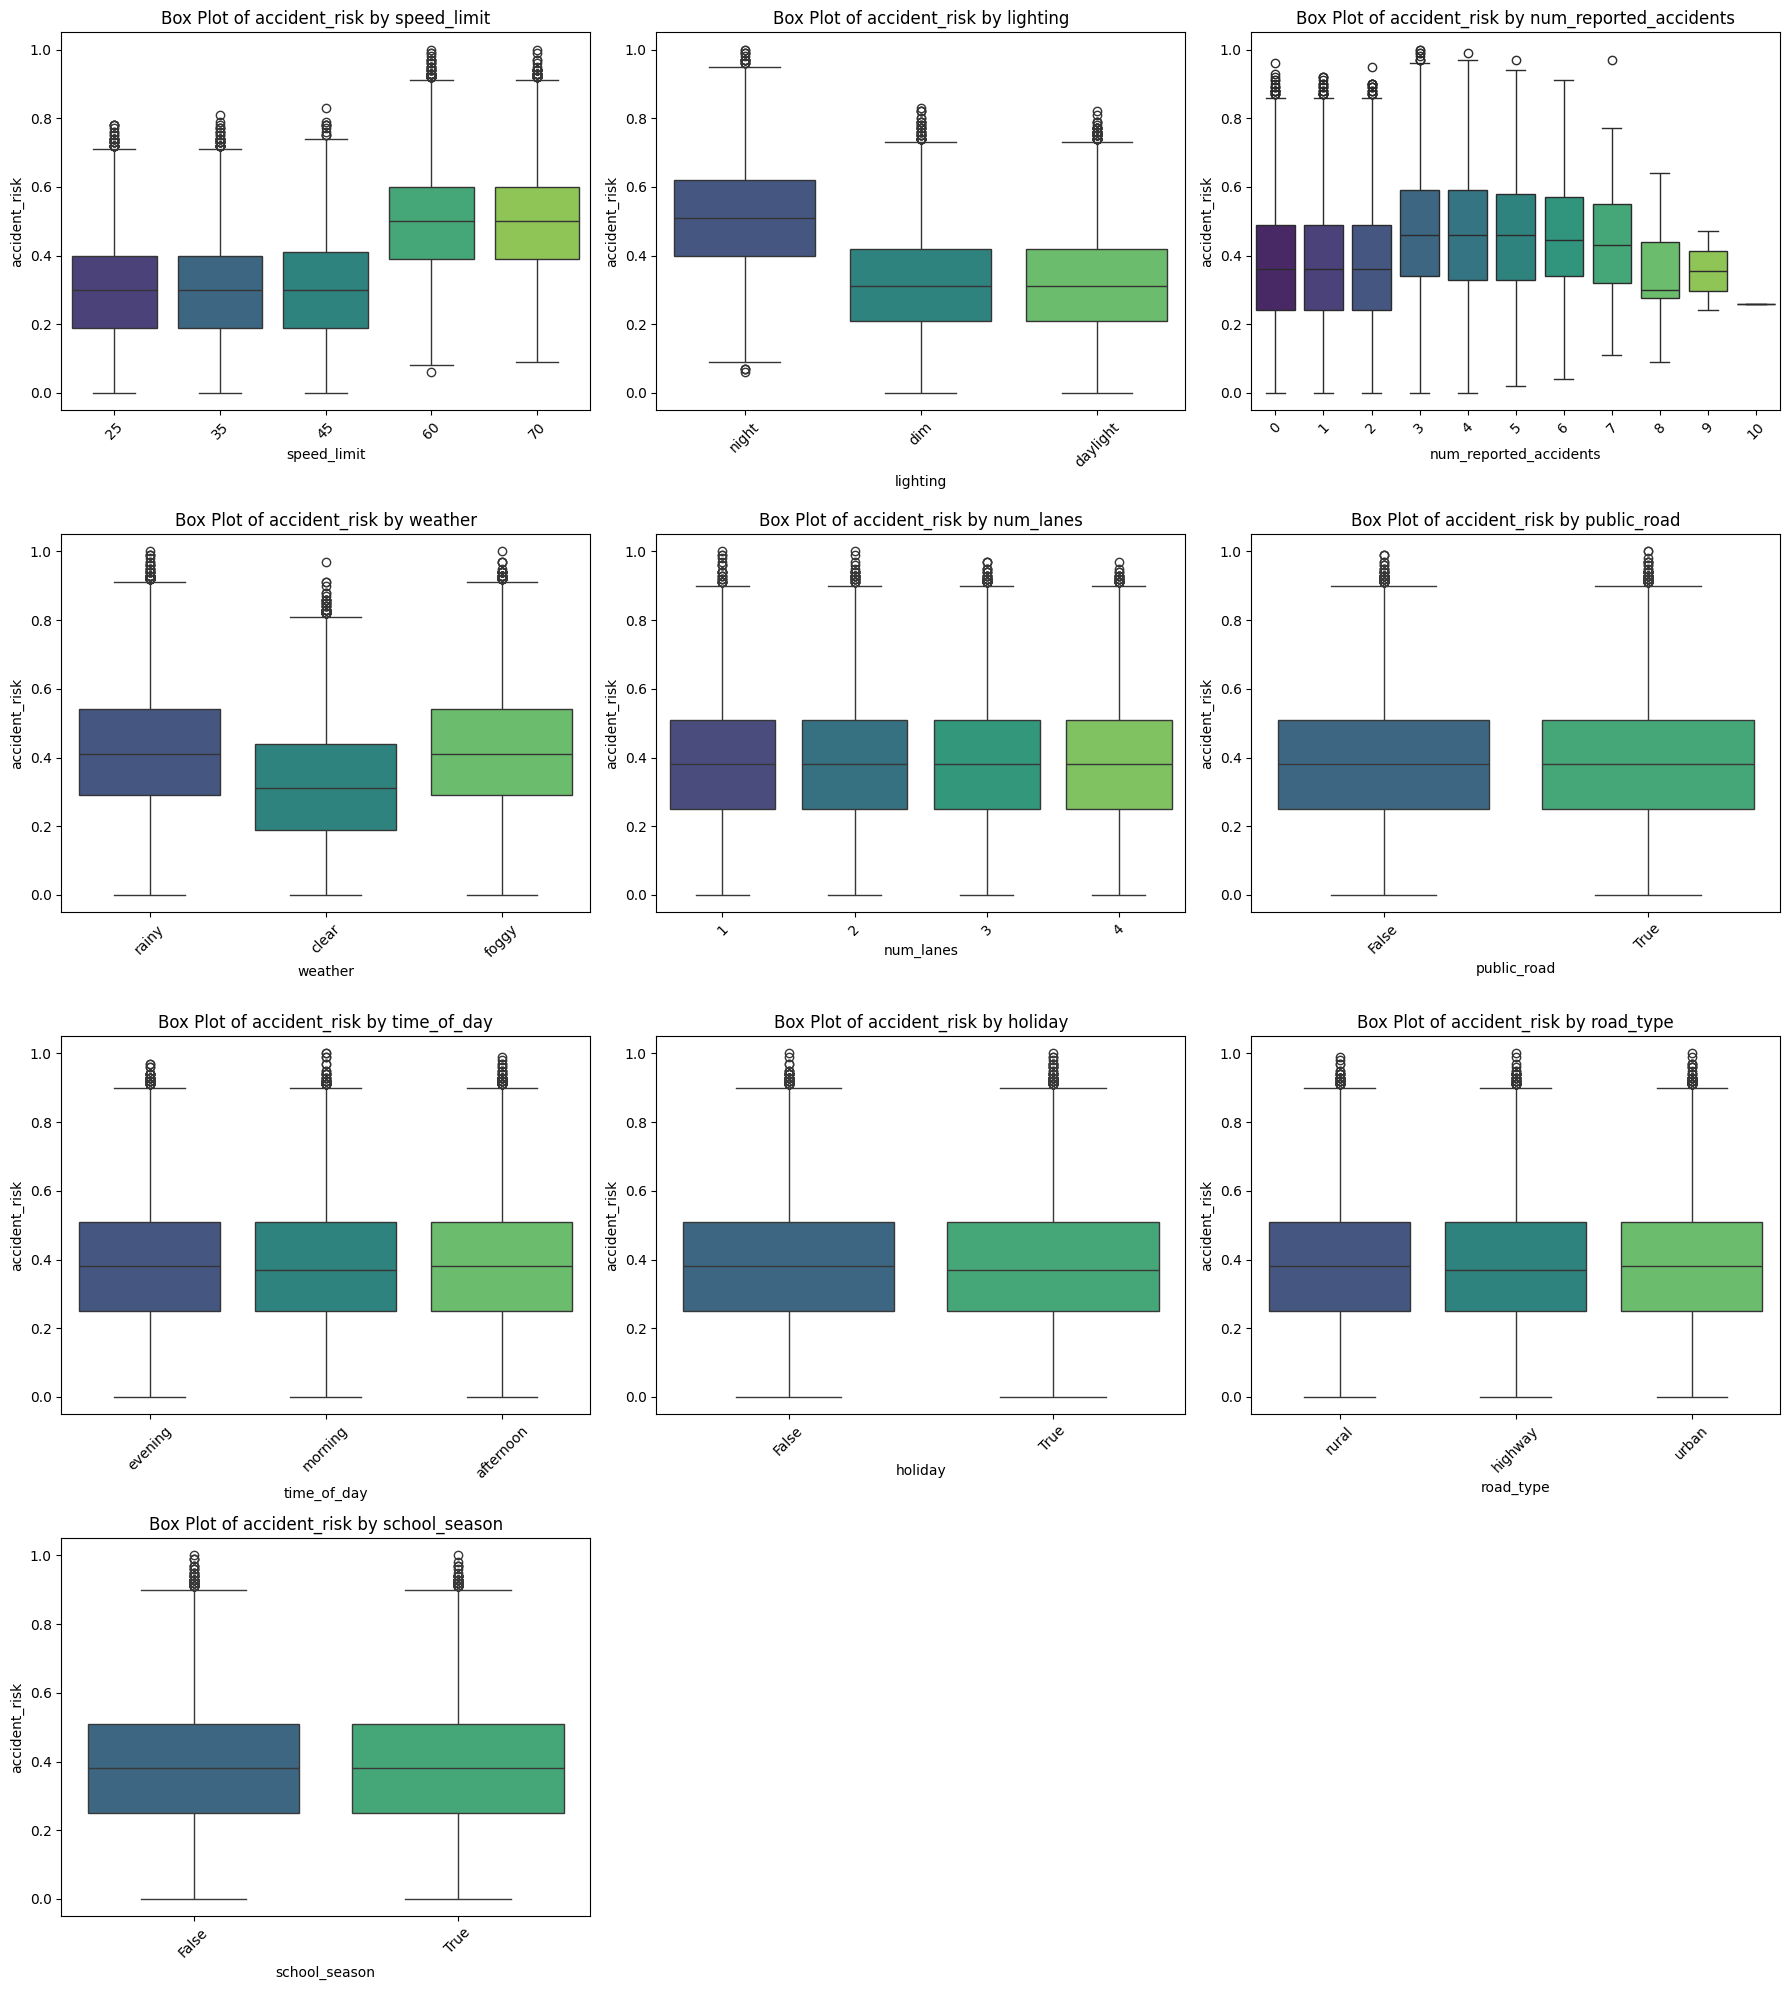

### Violin Plots

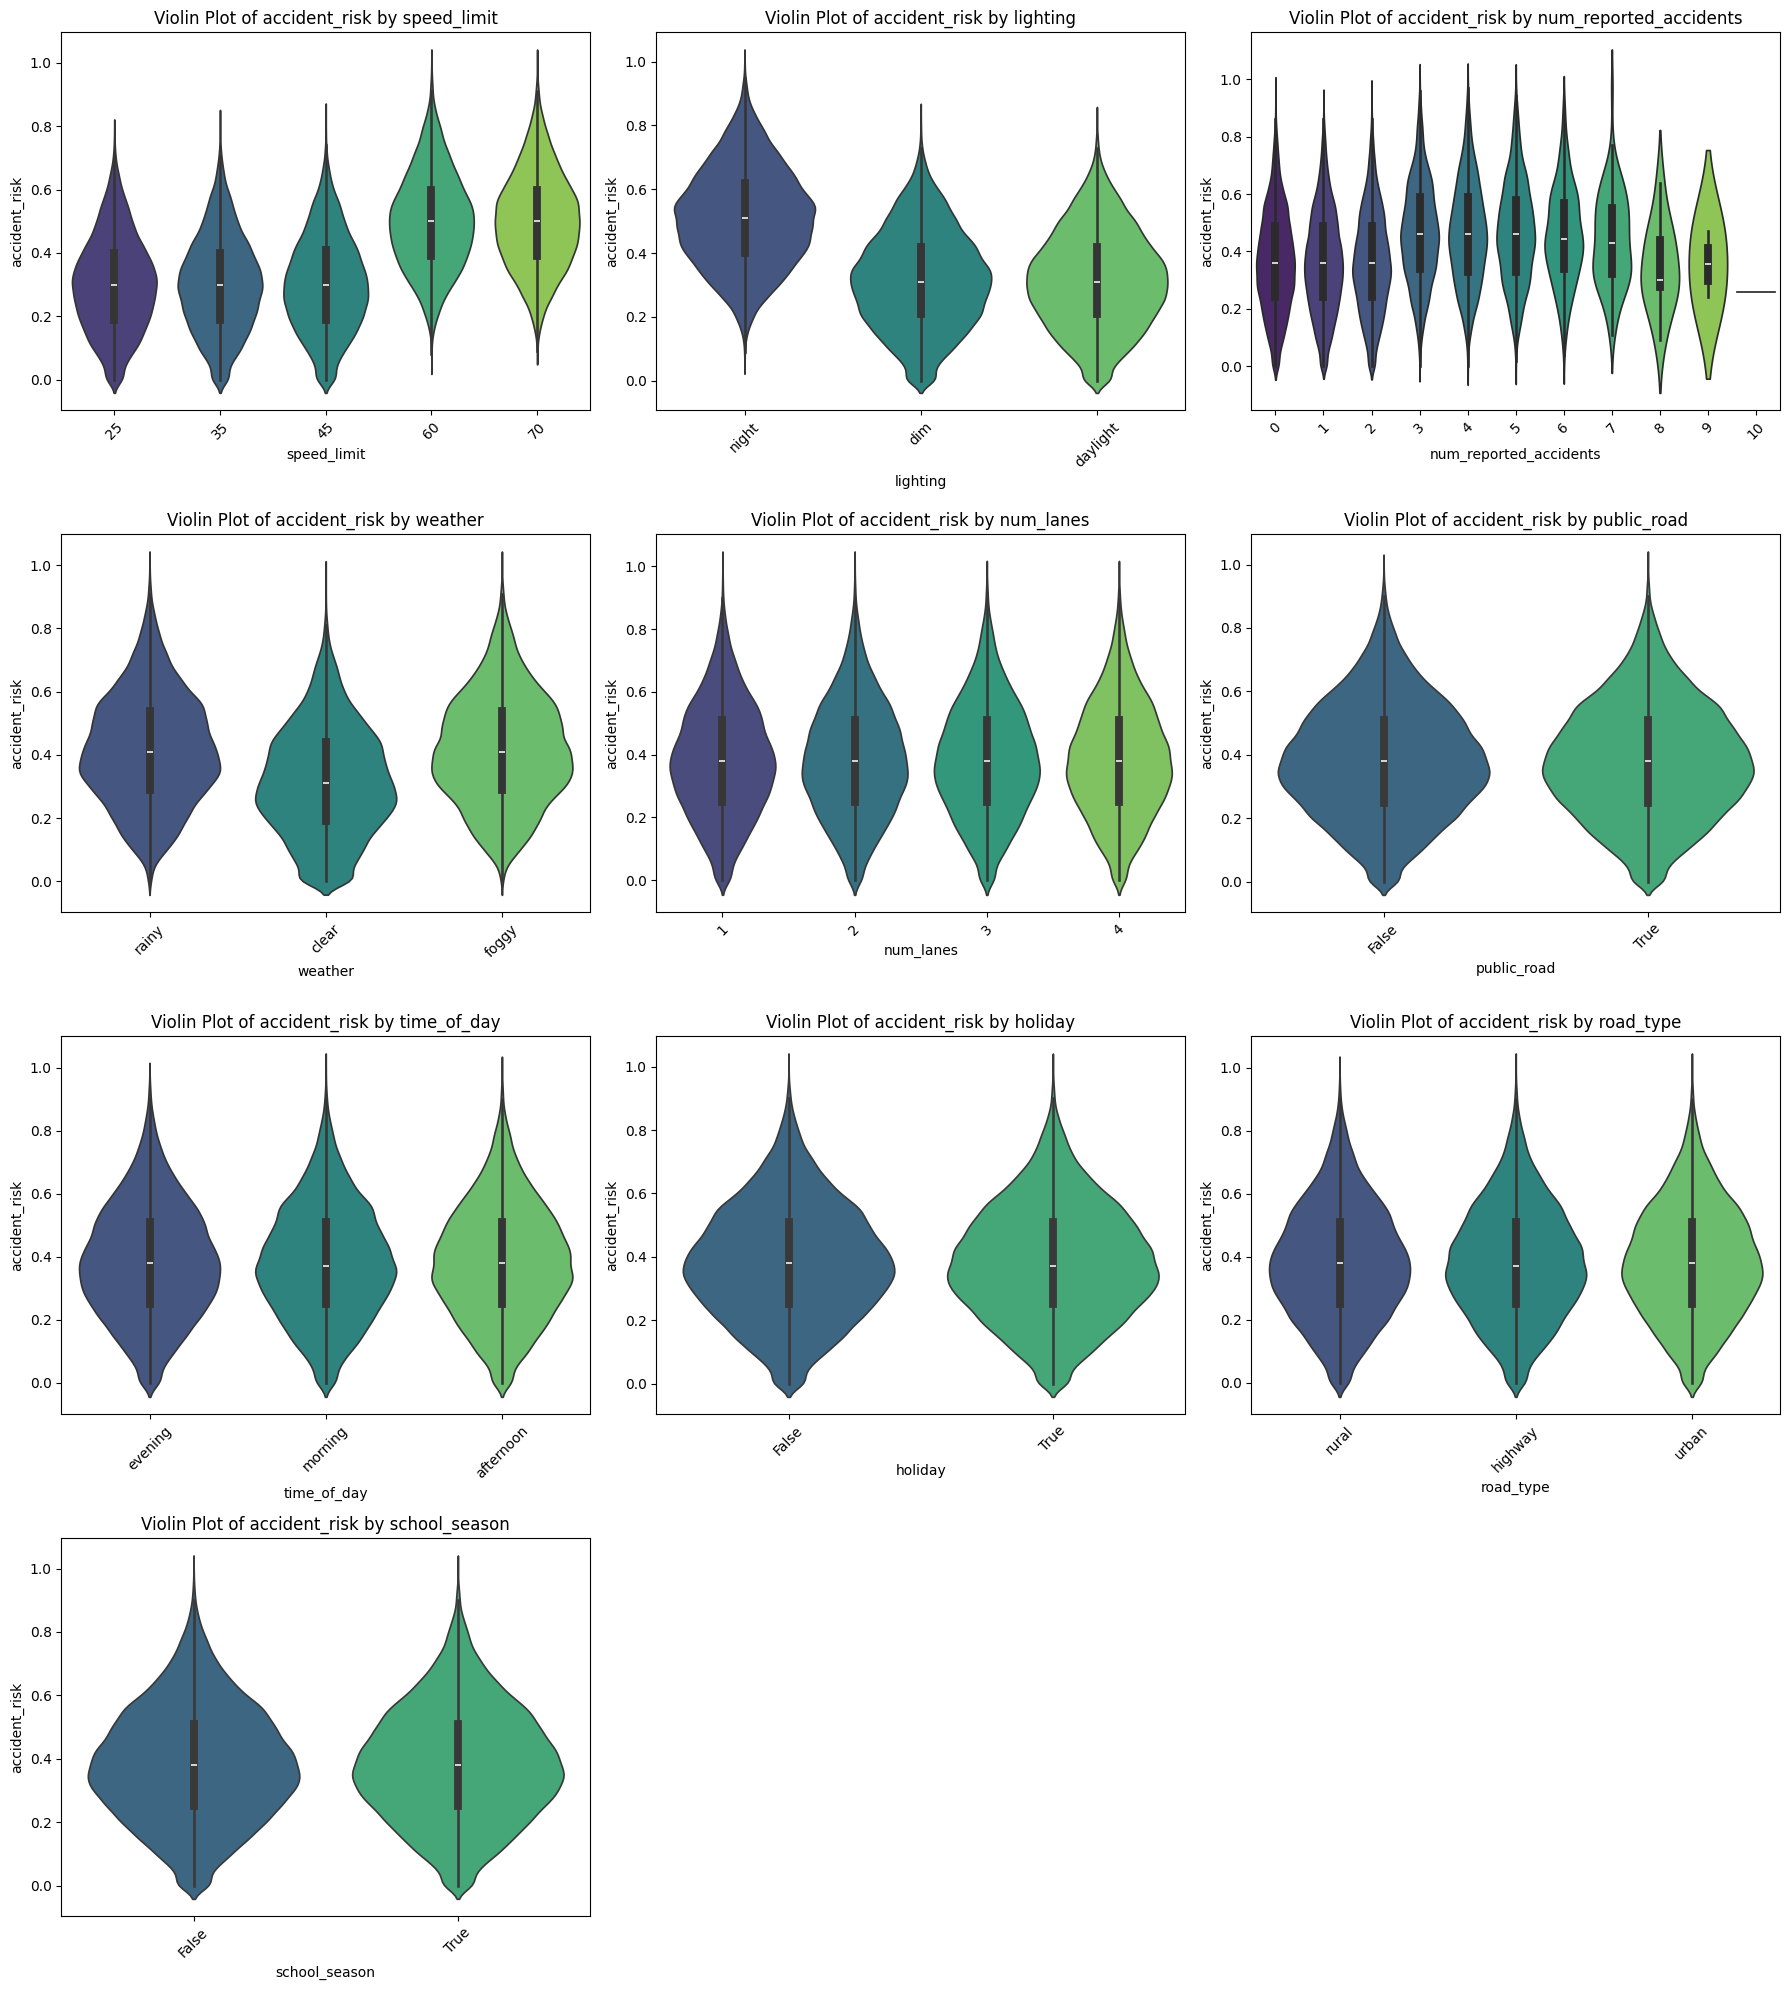

### Numeric × Categorical (Trend By Category)

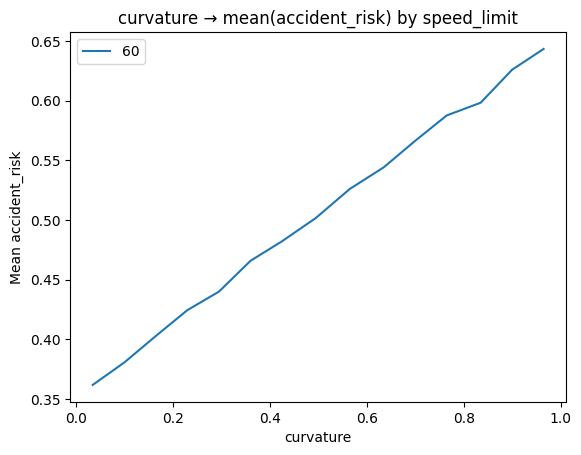

### Categorical × Categorical (Heatmap)

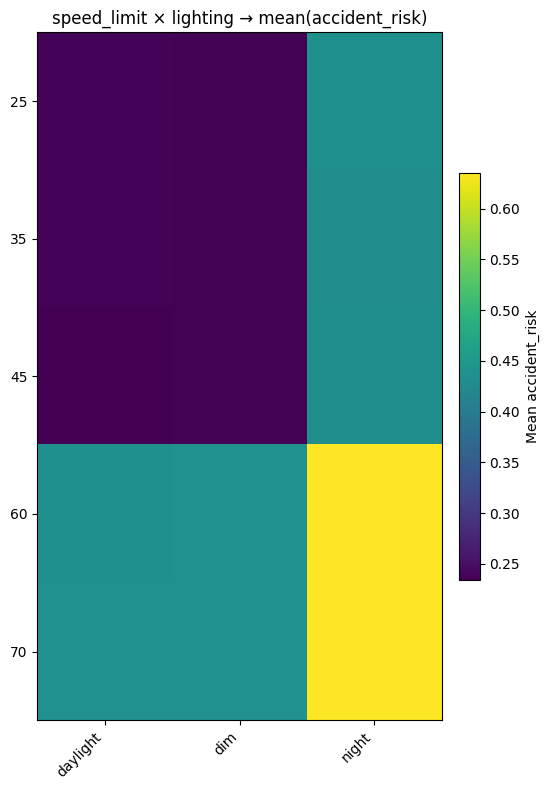

### Time of Day vs Risk Line

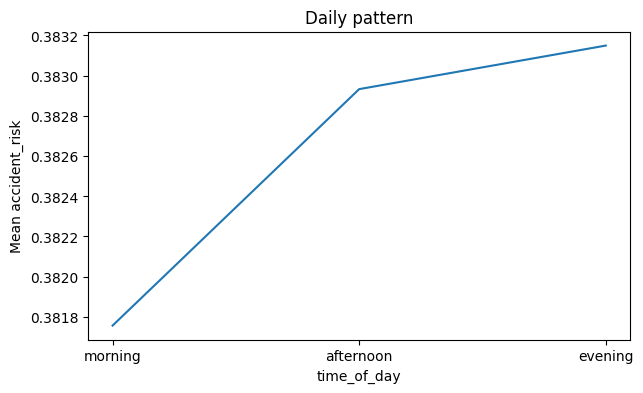

### Feature Signal Ranking

Top numeric (|Spearman|): [('speed_limit', 0.4755381706437699), ('curvature', 0.4694321426363731), ('num_reported_accidents', 0.14849663923552892), ('num_lanes', 0.0015855889200950967)]
Top categorical (range of mean risk): [('lighting', 0.197170074415491, 3), ('weather', 0.09975717725890859, 3), ('public_road', 0.0016333563844195265, 2), ('time_of_day', 0.001393338501637309, 3), ('holiday', 0.0013072121613361132, 2), ('road_type', 0.0007169961157473814, 3), ('school_season', 0.0005527101733853179, 2), ('road_signs_present', 0.00016134600929357257, 2)]


In [43]:
run_eda(original_df, target=TARGET, max_cat_card=30)

### Feature distributions

## Dataset Comparison Report

The exploratory data analysis reveals that the training and test datasets are remarkably similar, which is excellent for building a generalizable model. Here's a breakdown of the comparison:

*   **Data Structure and Quality**:
    
    *   Both datasets are clean with **no missing values**.
        
    *   The column types and feature names are consistent between the two sets (with the obvious exception of the accident\_risk target variable in the test set).
        
    *   Both datasets contain a small number of **duplicate rows** (656 in training, 1203 in testing). The training dupes might need to be removed before training to prevent any data leakage or bias.
        
*   **Feature Distributions**:
    
    *   **Numerical Features**: The distributions of curvature, speed\_limit, num\_lanes, and num\_reported\_accidents are nearly identical across both the training and test sets. The summary statistics (mean, std, min, max, etc.) are also very closely aligned. This indicates that the test set is a representative sample of the training data.
        
    *   **Categorical Features**: The value counts for categorical features like road\_type, lighting, weather, and time\_of\_day show very similar proportions in both datasets. There is no significant drift in the categorical distributions, which is favorable for model training.
        
    *   **Boolean Features**: Similarly, the boolean features (road\_signs\_present, public\_road, holiday, school\_season) have comparable distributions of True and False values.
        
*   **Correlations and Relationships**:
    
    *   The correlation matrices for the numerical features in both datasets are very similar. The relationships between features like curvature, speed\_limit, and num\_reported\_accidents are consistent.
        
    *   The box plots, violin plots, and pair plots on the training data reveal clear relationships between several features and the accident\_risk. Since the feature distributions are so similar in the test set, we can infer that these relationships will likely hold, which is a positive indicator for the model's predictive power.
        

In summary, the high degree of similarity between the training and test datasets suggests that a model trained on this data should perform well on the unseen test data without needing complex adjustments for distribution shifts

## Feature Engineering

Based on the EDA, here are some suggested next steps for feature engineering to enhance a model's performance:

1.  **Handle Categorical Features**:
    
    *   The categorical features (road\_type, lighting, weather, time\_of\_day) have low cardinality. **One-hot encoding** is a suitable approach here.
        
2.  **Create Interaction Features**:
    
    *   The EDA shows that curvature and speed\_limit are the two features most strongly correlated with accident\_risk. It's highly likely that their interaction is also significant.
        
    *   Consider other potentially meaningful interactions, especially between numerical and categorical features. For example, the effect of curvature might be different on a highway versus a rural road.
        
3.  **Polynomial Features**:
    
    *   Since curvature and speed\_limit show strong, somewhat linear relationships with the target, we should explore creating polynomial features from them to capture any non-linear effects. sklearn.preprocessing.PolynomialFeatures is a good tool for this.
        
4.  **Address the Leaky Feature**:
    
    *   The num\_reported\_accidents feature is a potential source of data leakage, as it's correlated with the target. While it's not a perfect predictor (meaning it's "leaky" rather than a direct spoiler), we should use it with caution. Here are a couple of strategies:
        
        *   **Drop the feature**: The simplest approach is to remove it entirely to avoid any risk of leakage.
            
        *   **Feature Engineering**: Create aggregate features from it. For example, we could calculate the average accident\_risk per num\_reported\_accidents in the training set and then use this as a new feature. Be careful to do this in a way that doesn't leak target information during cross-validation.
            
5.  **Binning Numerical Features**:
    
    *   While the relationships appear fairly linear, we could experiment with binning some of the numerical features, like speed\_limit, into categories (e.g., 'low', 'medium', 'high'). This can sometimes help tree-based models identify more distinct patterns.
        
6.  **Time-Based Features**:
    
    *   The time\_of\_day feature is categorical, but we could also treat it as an ordered feature. Given the daily pattern observed in the "Time of Day vs Risk" plot, we could encode it numerically (e.g., morning=1, afternoon=2, evening=3) to see if that captures the trend better for some models.

In [44]:
# Identify Feature Types
# Instead of one-hot encoding, we'll tell LightGBM which columns are categorical.
categorical_features = [
    'road_type', 'lighting', 'weather', 'time_of_day', 'holiday_x_lighting',
    'weather_lighting', 'curvature_bin', 'speed_x_curvature_bin'
]

def feature_engineer(df: pd.DataFrame, target: str = TARGET, drop_duplicates:bool = True) -> pd.DataFrame:
    """
    Applies feature engineering steps to the road accident dataset.

    Args:
        df (pd.DataFrame): The input DataFrame (either training or test data).

    Returns:
        pd.DataFrame: The DataFrame with engineered features.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_engineered = df.copy()

    # If requested, remove any duplicate rows
    if drop_duplicates:
        df_engineered = df_engineered.drop_duplicates()

    # 
    # Create Interaction Features
    # Interaction between speed limit and road curvature
    # Add a small epsilon to curvature to prevent division by zero
    df_engineered['speed_curvature_ratio'] = df_engineered['speed_limit'] / (df_engineered['curvature'] + 1e-6)

    # Combined environmental conditions
    df_engineered['weather_lighting'] = df_engineered['weather'].astype(str) + '_' + df_engineered['lighting'].astype(str)

    # New Feature: Binning Curvature
    # Create categorical bins for the curvature feature.
    # The quantiles are chosen to split the data into meaningful groups.
    df_engineered['curvature_bin'] = pd.qcut(
        df_engineered['curvature'],
        q=[0, 0.25, 0.75, 1.0],
        labels=['low', 'medium', 'high']
    ).astype(str)

    # Create Polynomial Features
    # Squaring the most correlated features to capture non-linear relationships
    df_engineered['curvature_sq'] = df_engineered['curvature'] ** 2
    df_engineered['speed_limit_sq'] = df_engineered['speed_limit'] ** 2

    # More Advanced Interactions
    # Interact the new curvature bins with the speed limit.
    df_engineered['speed_x_curvature_bin'] = df_engineered['speed_limit'].astype(str) + '_' + df_engineered['curvature_bin']

    # Time-based Interactions
    # The effect of lighting might differ on a holiday.
    df_engineered['holiday_x_lighting'] = df_engineered['holiday'].astype(str) + '_' + df_engineered['lighting'].astype(str)

    # Convert boolean features to integers for the model
    bool_cols = df_engineered.select_dtypes(include='bool').columns
    df_engineered[bool_cols] = df_engineered[bool_cols].astype(int)

    # Convert categorical columns to the 'category' dtype for LightGBM
    for col in categorical_features:
        df_engineered[col] = df_engineered[col].astype('category')

    return df_engineered

In [45]:
X_training = feature_engineer(training_df)

# Separate the target from the data, but leave it in for EDA
y_training = X_training[TARGET].copy()

X_test = feature_engineer(test_df, drop_duplicates = False)

### Examine the Engineered Training Dataset

### Pair Plots

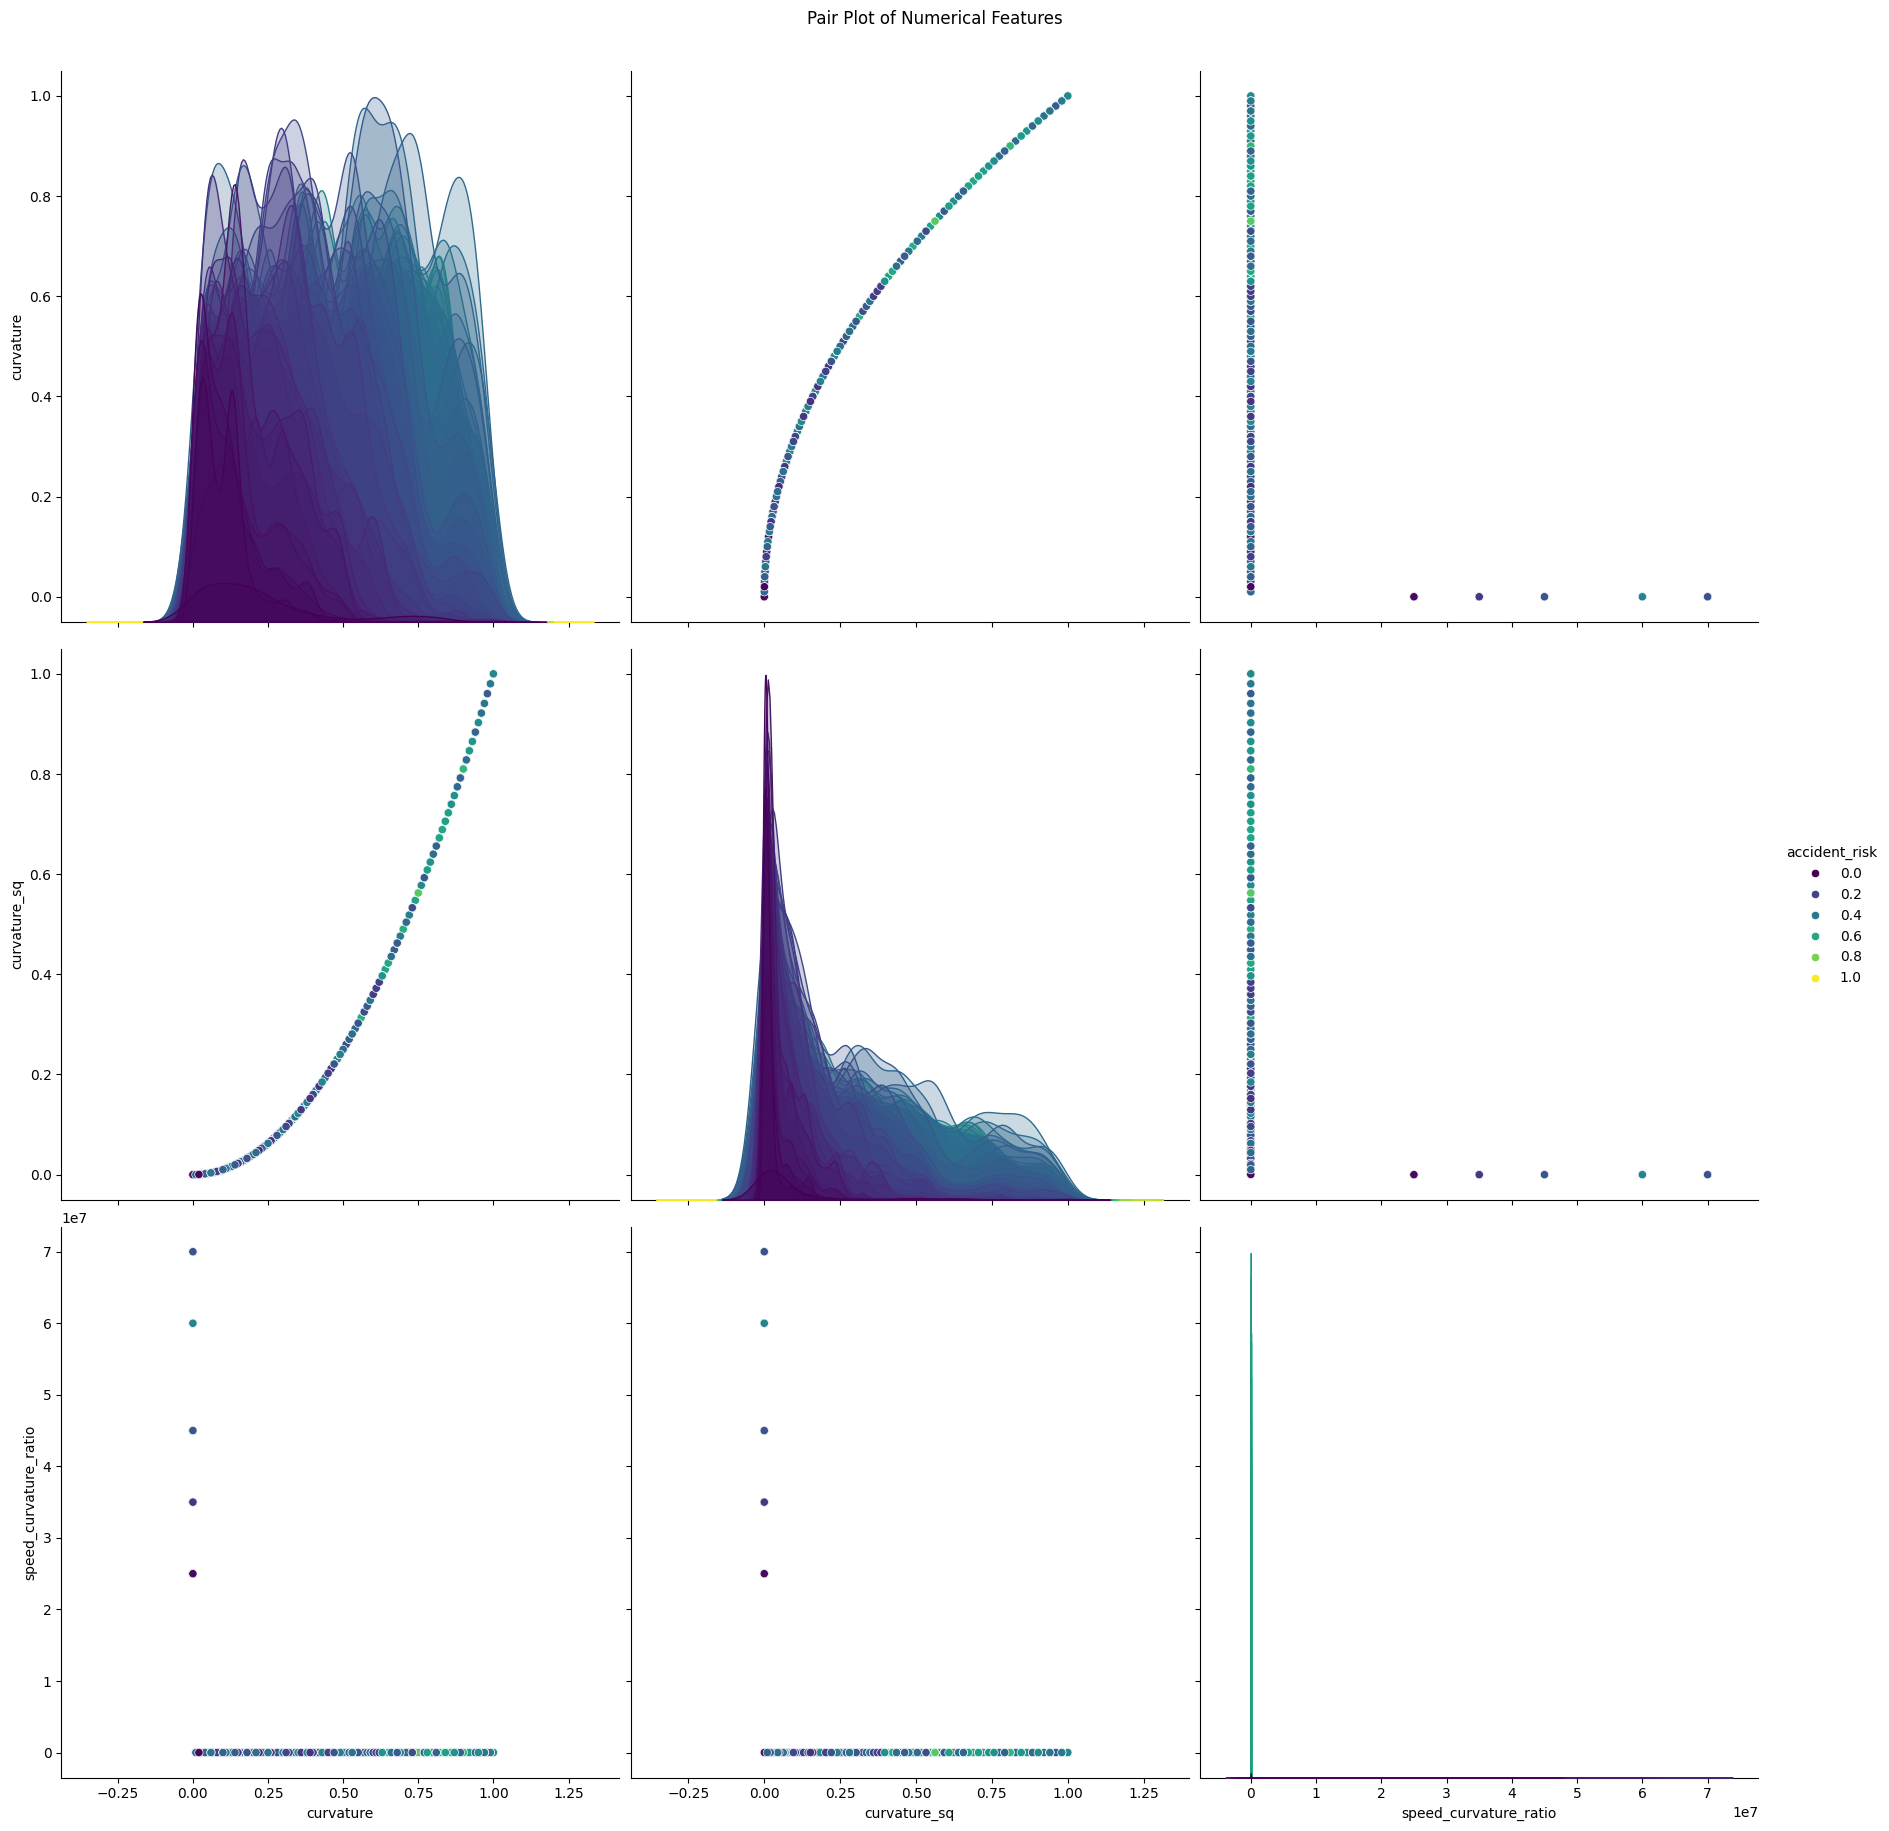

### Box Plots

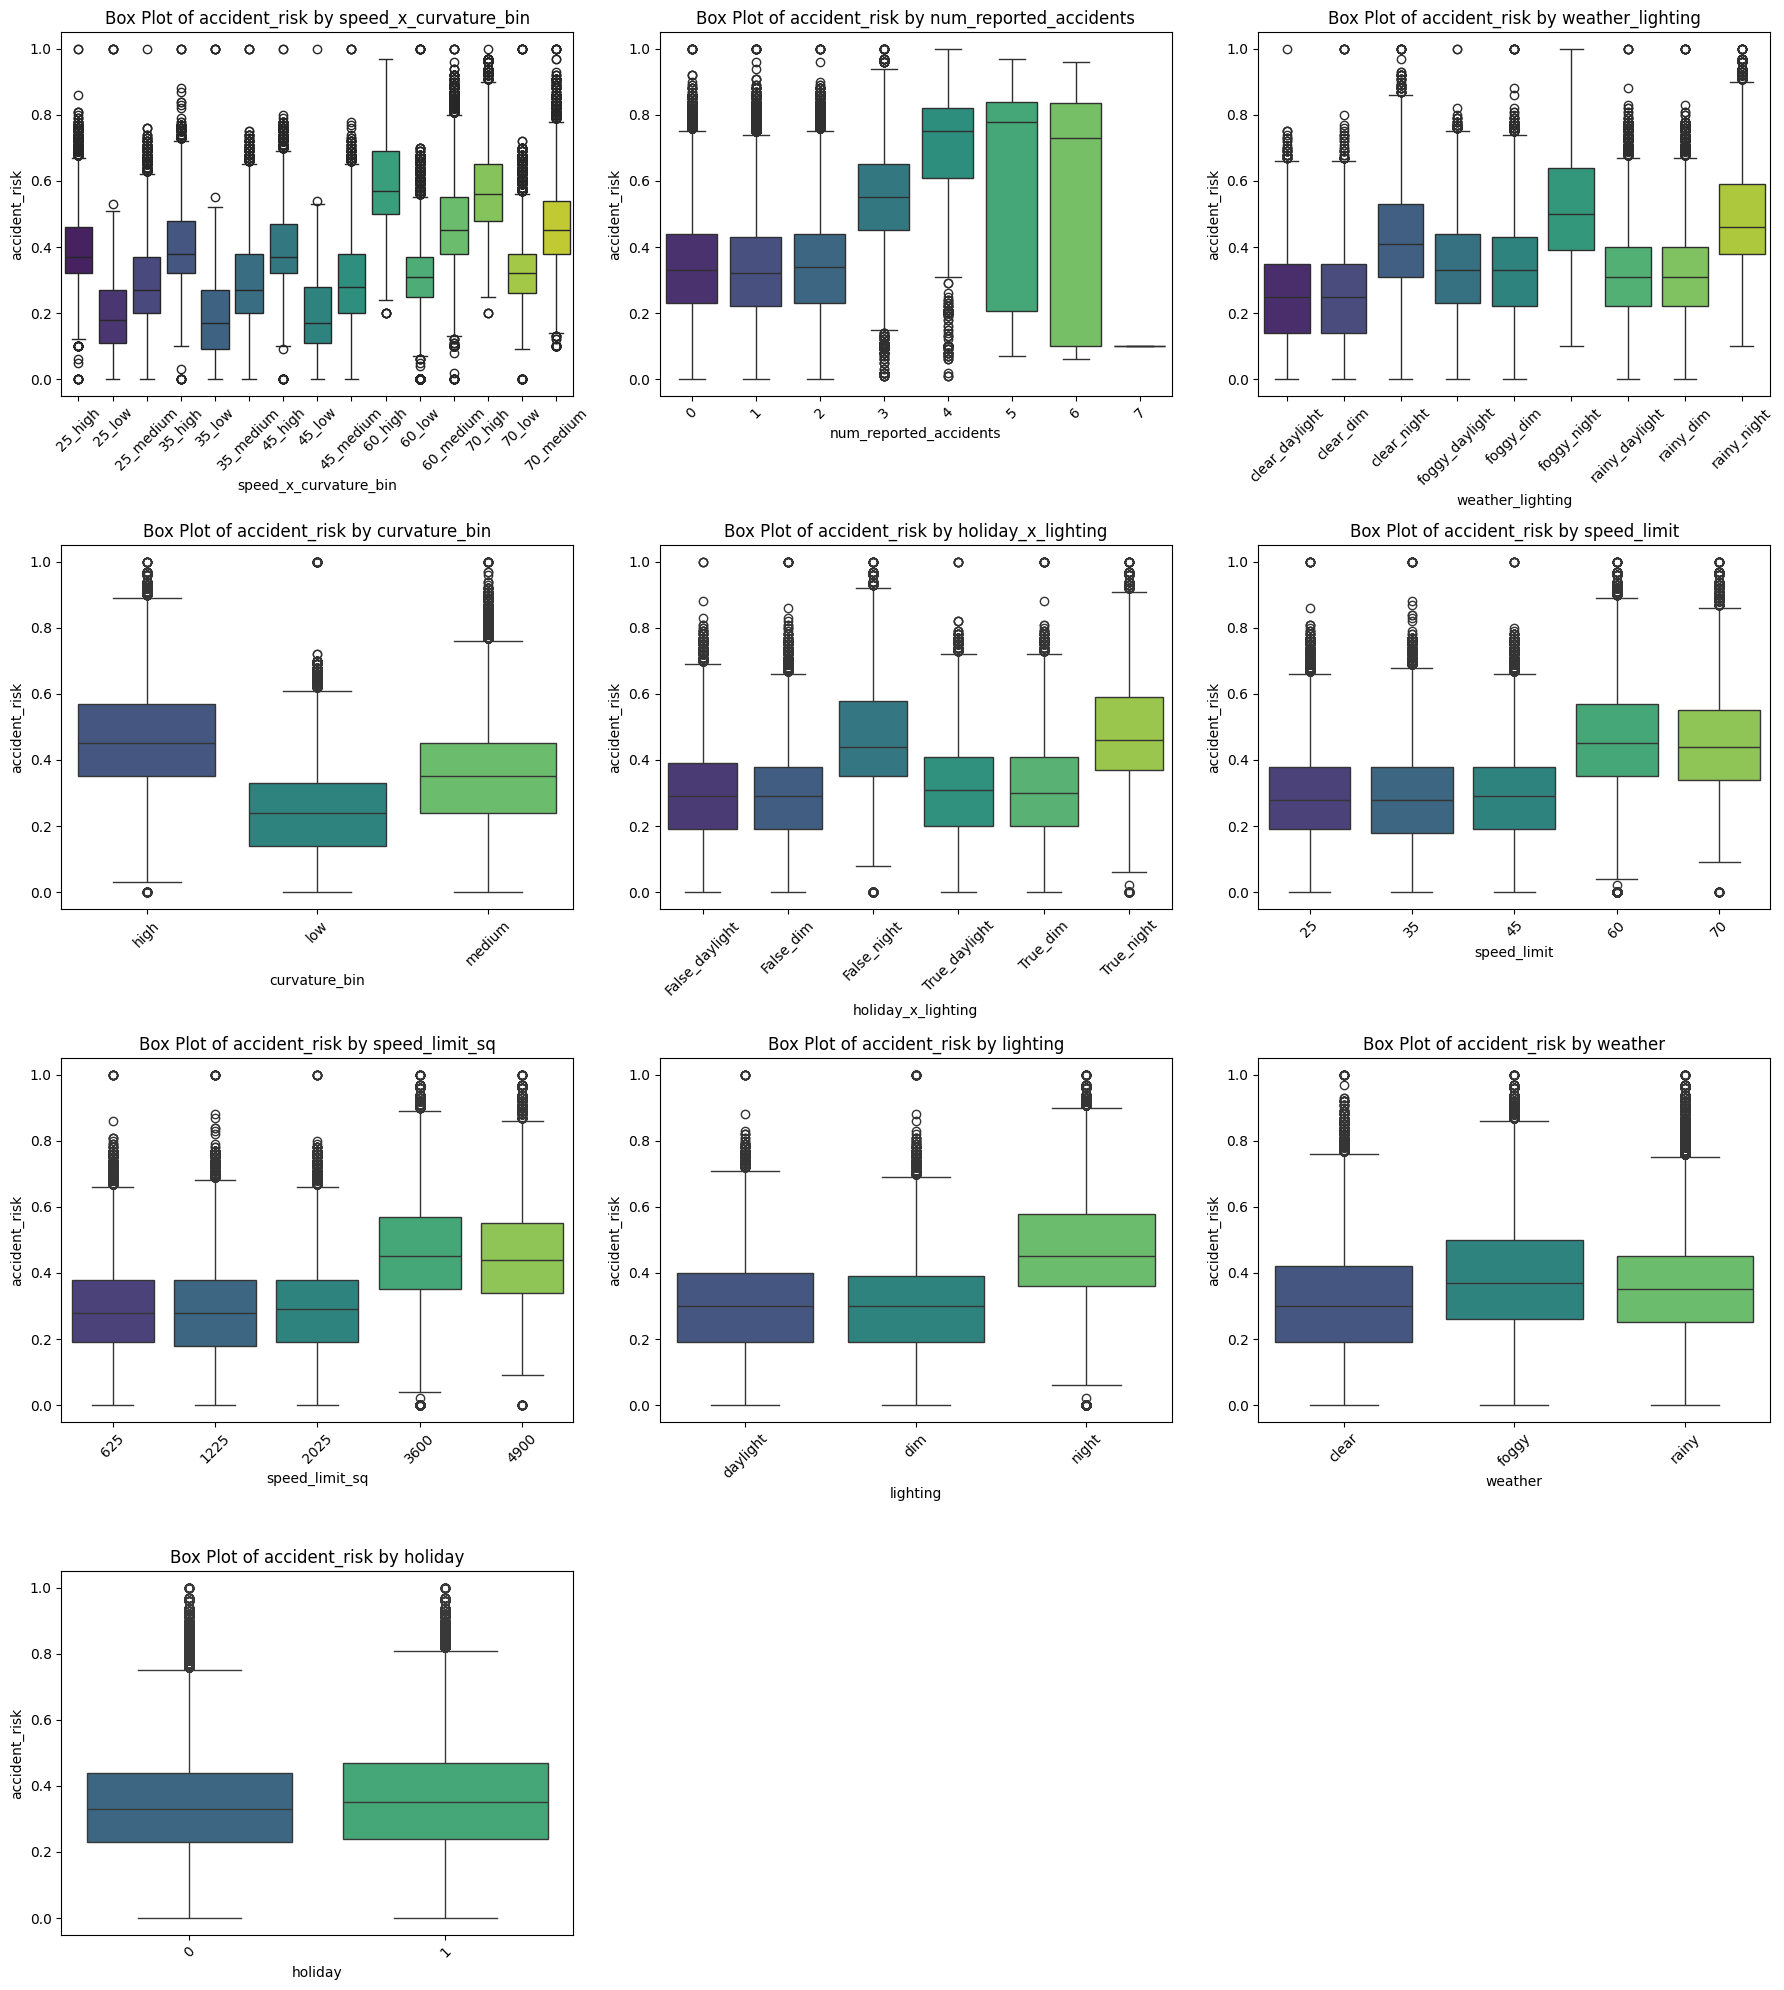

### Violin Plots

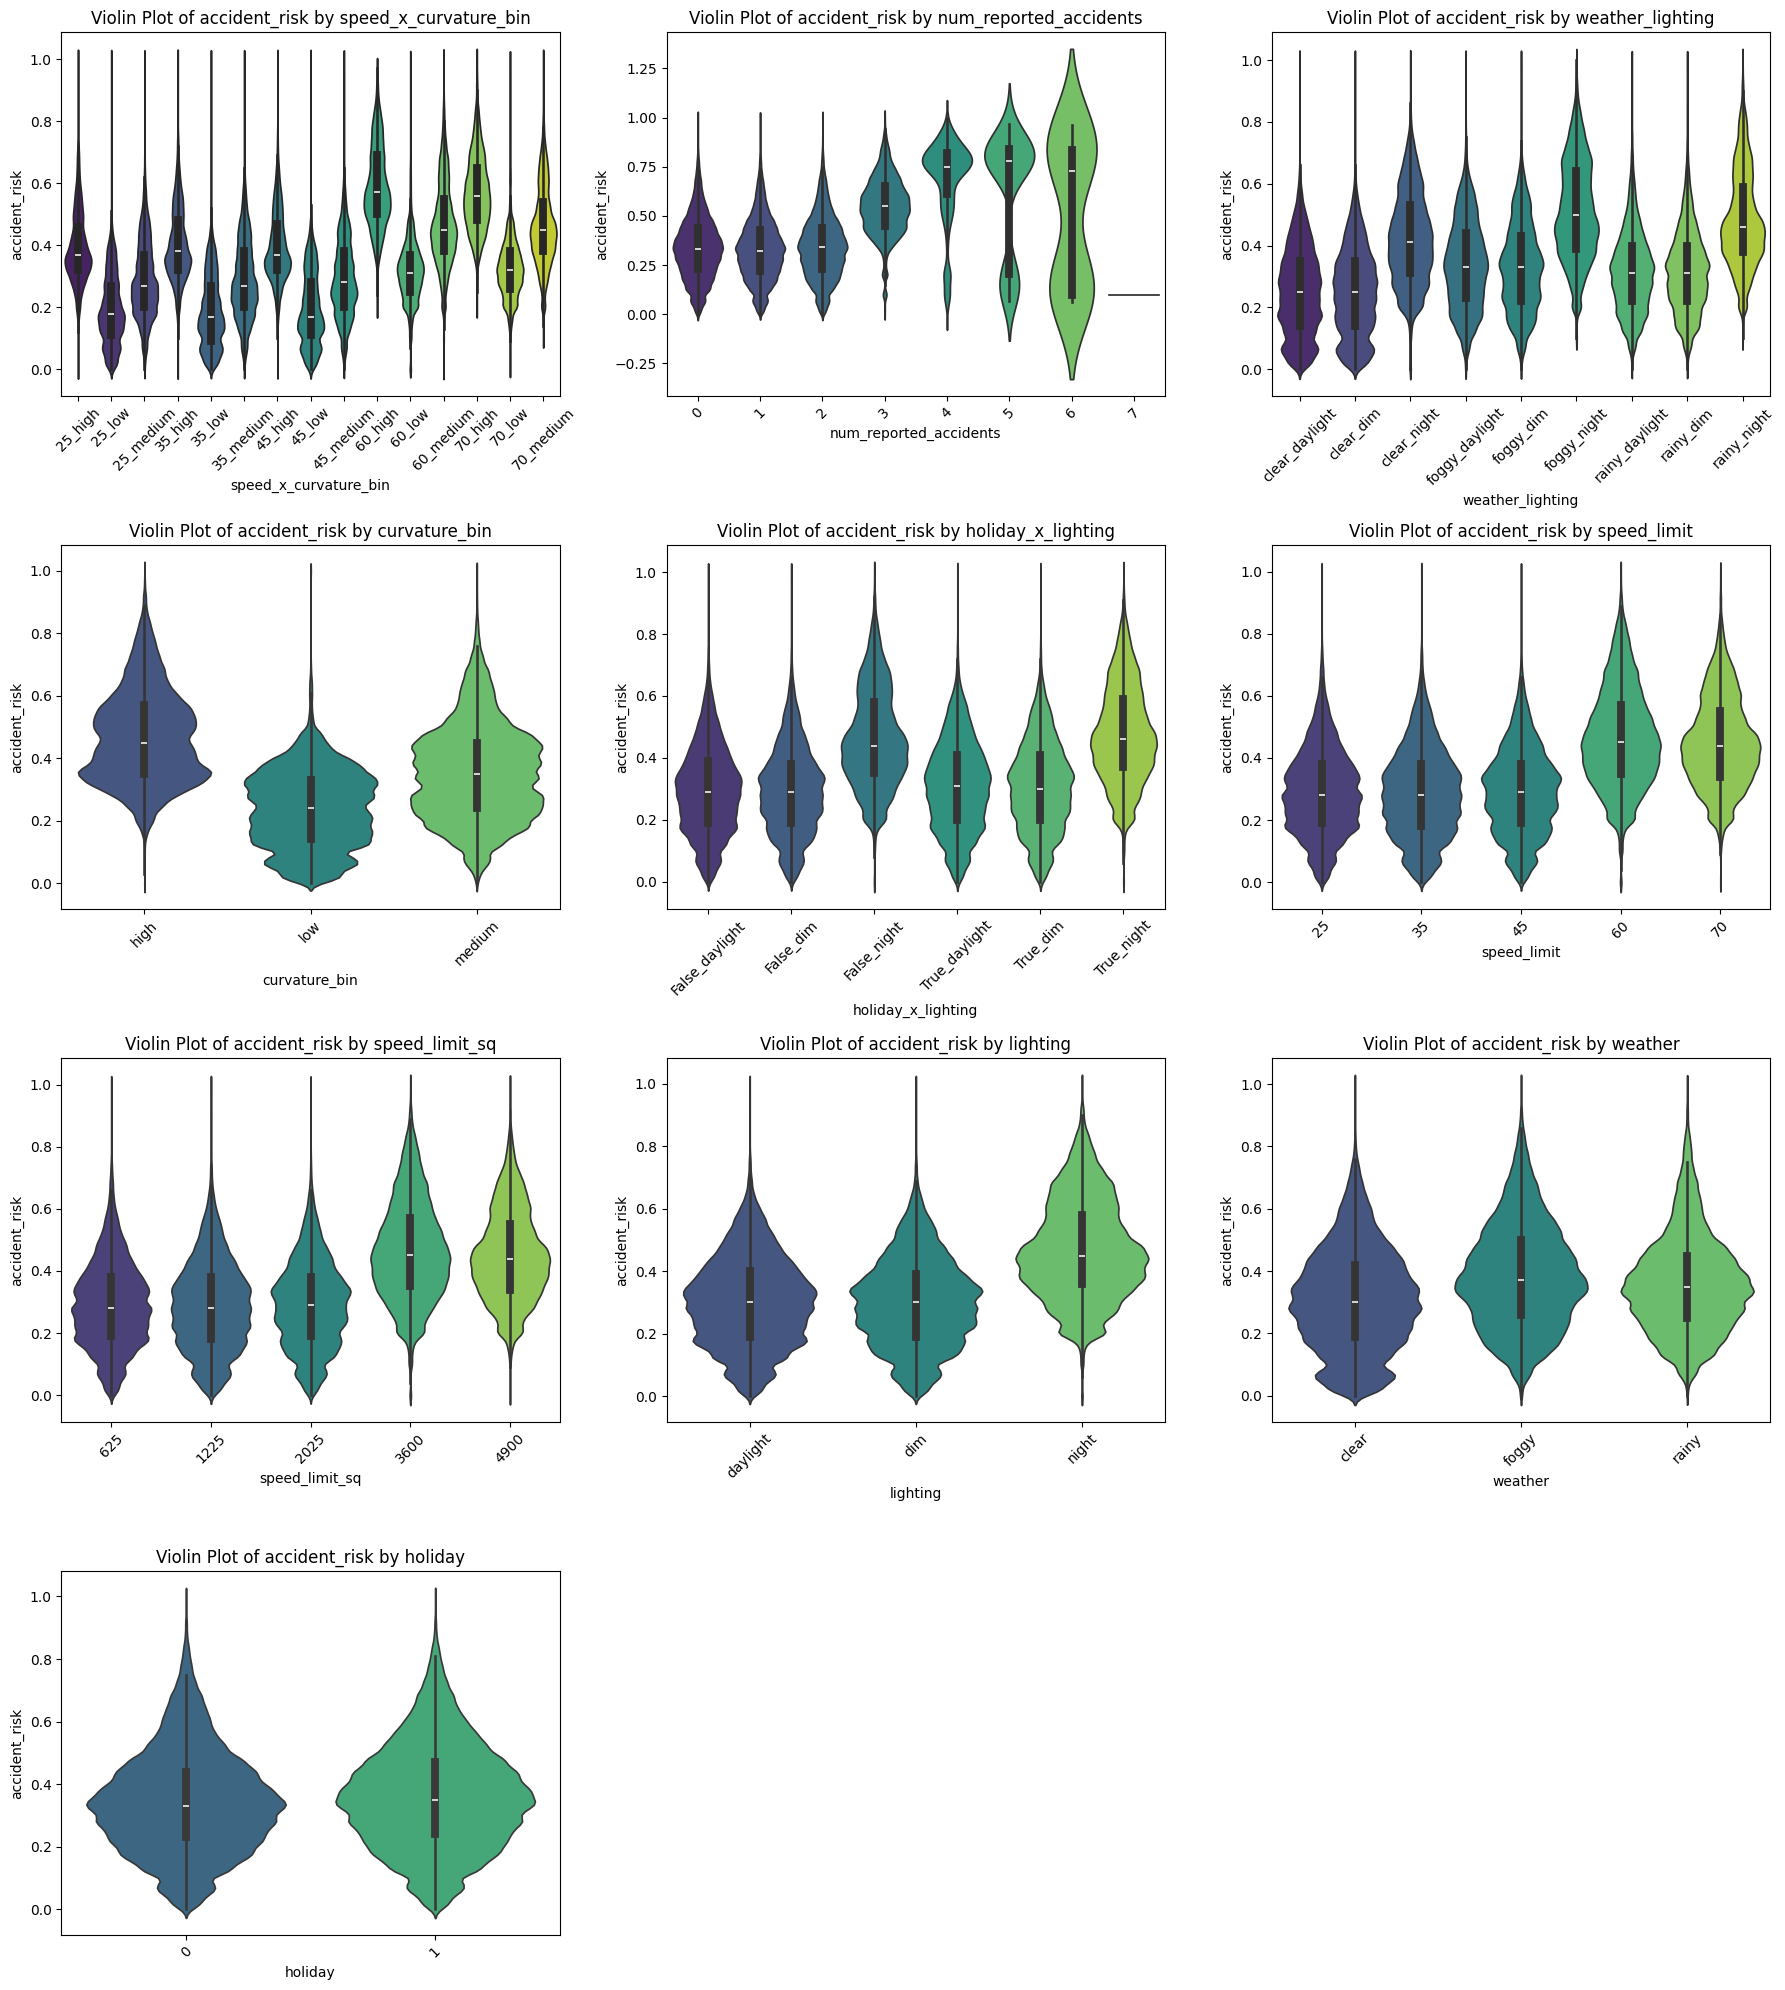

### Numeric × Categorical (Trend By Category)

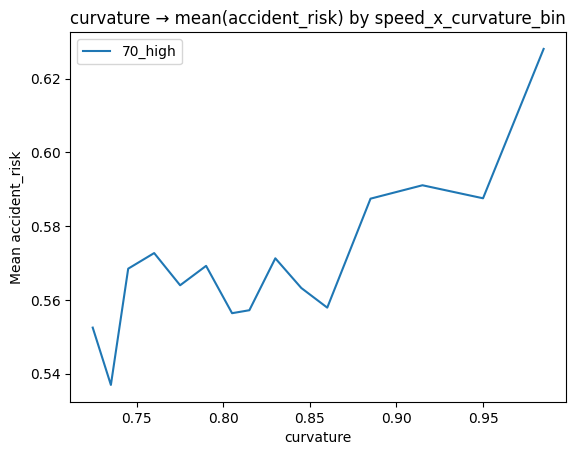

### Categorical × Categorical (Heatmap)

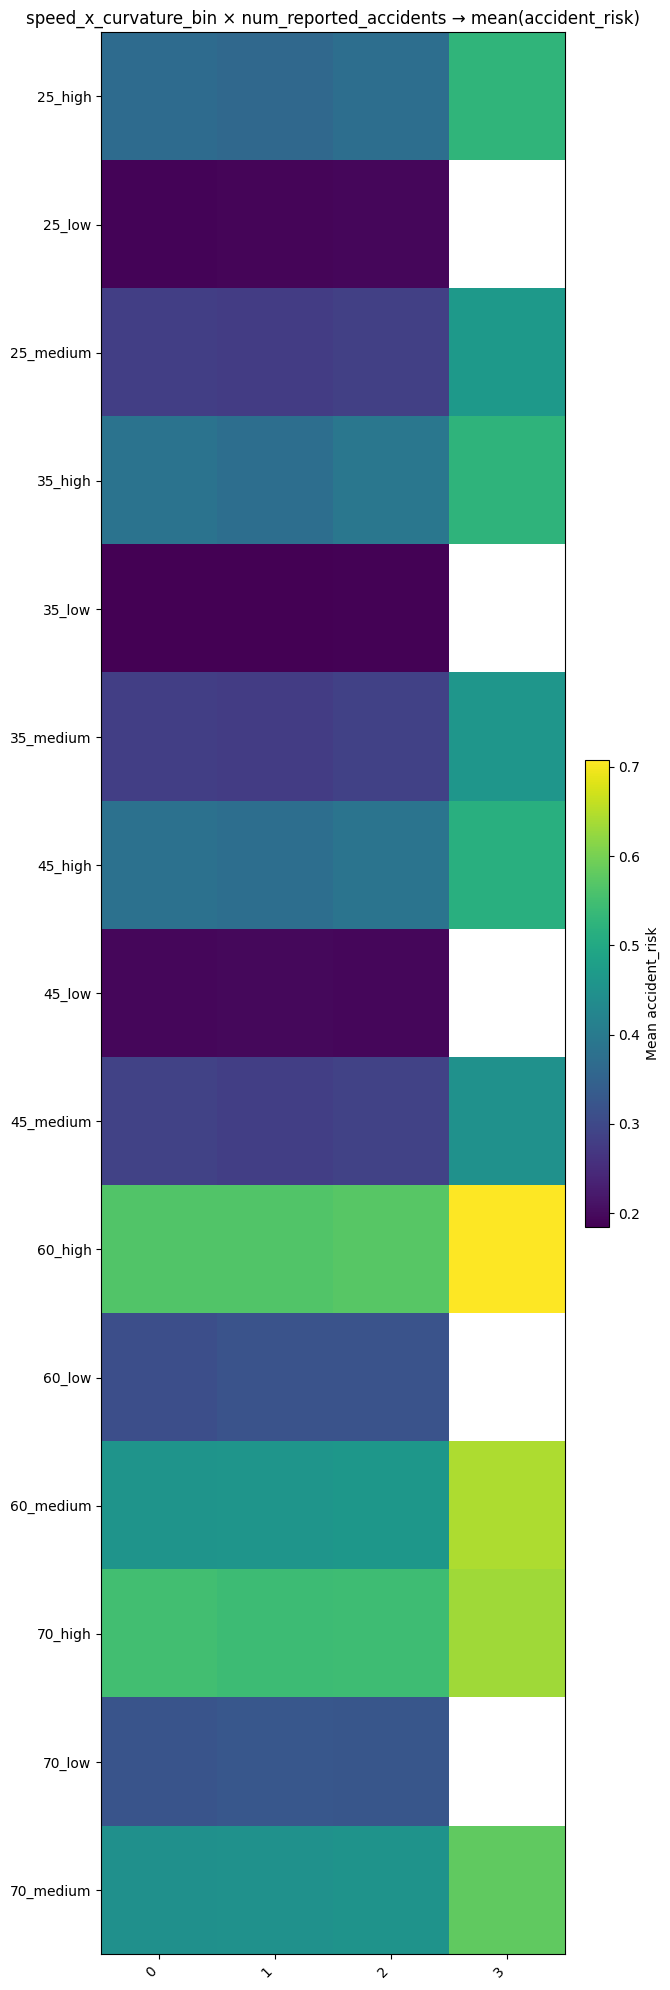

### Numeric × Numeric (Hexbin Target Mean)

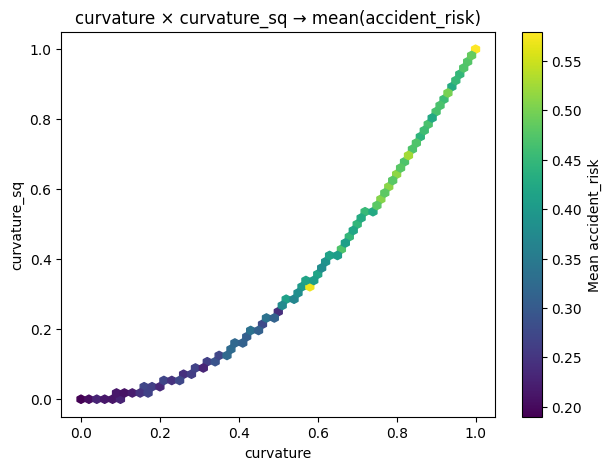

### Time of Day vs Risk Line

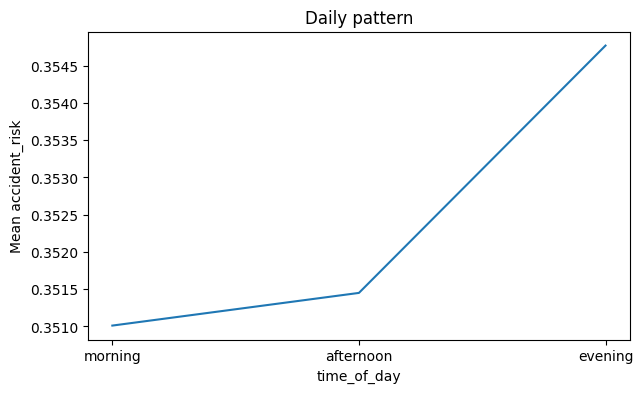

### Feature Signal Ranking

Top numeric (|Spearman|): [('curvature', 0.5467047744658393), ('curvature_sq', 0.5467047744658393), ('speed_limit', 0.40911509015038255), ('speed_limit_sq', 0.40911509015038255), ('speed_curvature_ratio', -0.27608357451128707), ('num_reported_accidents', 0.15435973493829722), ('holiday', 0.05412077808108874), ('public_road', 0.03245176066433195), ('num_lanes', -0.007260971723255501), ('school_season', 0.00010299975013938791)]
Top categorical (range of mean risk): [('speed_x_curvature_bin', 0.40440470889879854, 15), ('weather_lighting', 0.26586318208668513, 9), ('curvature_bin', 0.23208302060501337, 3), ('holiday_x_lighting', 0.18405261645357518, 6), ('lighting', 0.17033254209903953, 3), ('weather', 0.07619717038475371, 3), ('road_type', 0.007708265954065097, 3), ('time_of_day', 0.003757193119423241, 3)]


In [46]:
run_eda(X_training, target = TARGET)

In [47]:
X_training.drop(TARGET, axis=1, inplace=True)

## Model Training

### Define, Train, and Evaluate the LightGBM Model

Performing feature engineering on the test set...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822497	valid_1's rmse: 0.0820552
[200]	training's rmse: 0.0609374	valid_1's rmse: 0.0607047
[300]	training's rmse: 0.0570528	valid_1's rmse: 0.056824
[400]	training's rmse: 0.0563269	valid_1's rmse: 0.056111
[500]	training's rmse: 0.0561254	valid_1's rmse: 0.0559375
[600]	training's rmse: 0.056022	valid_1's rmse: 0.0558685
[700]	training's rmse: 0.0559528	valid_1's rmse: 0.0558364
[800]	training's rmse: 0.0558977	valid_1's rmse: 0.0558174
[900]	training's rmse: 0.0558495	valid_1's rmse: 0.0558032
[1000]	training's rmse: 0.0558055	valid_1's rmse: 0.055794
[1100]	training's rmse: 0.0557647	valid_1's rmse: 0.0557884
[1200]	training's rmse: 0.0557255	valid_1's rmse: 0.0557829
[1300]	training's rmse: 0.055689	valid_1's rmse: 0.0557778
[1400]	training's rmse: 0.0556539	valid_1's rmse: 0.0557731
[1500]	training's rmse: 0.0556203	valid_1's rmse: 0.0557707
[1

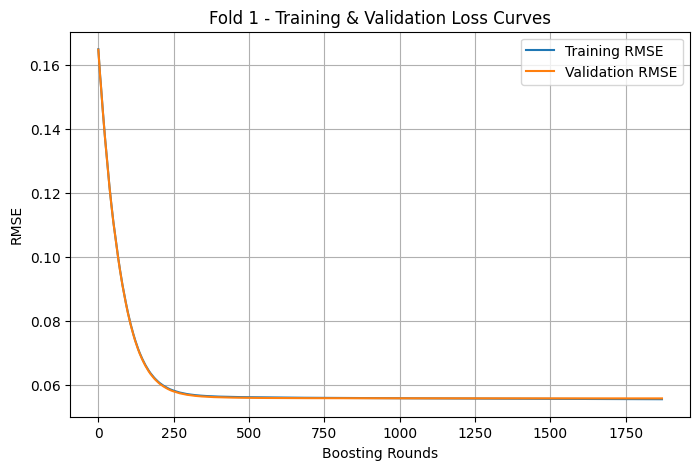

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822445	valid_1's rmse: 0.0821137
[200]	training's rmse: 0.0609261	valid_1's rmse: 0.0608098
[300]	training's rmse: 0.0570386	valid_1's rmse: 0.0569581
[400]	training's rmse: 0.0563106	valid_1's rmse: 0.0562617
[500]	training's rmse: 0.0561096	valid_1's rmse: 0.0560934
[600]	training's rmse: 0.0560098	valid_1's rmse: 0.0560216
[700]	training's rmse: 0.0559388	valid_1's rmse: 0.0559819
[800]	training's rmse: 0.0558827	valid_1's rmse: 0.0559559
[900]	training's rmse: 0.0558354	valid_1's rmse: 0.0559376
[1000]	training's rmse: 0.0557906	valid_1's rmse: 0.0559227
[1100]	training's rmse: 0.0557501	valid_1's rmse: 0.0559116
[1200]	training's rmse: 0.0557125	valid_1's rmse: 0.0559037
[1300]	training's rmse: 0.0556764	valid_1's rmse: 0.055896
[1400]	training's rmse: 0.055641	valid_1's rmse: 0.055891
[1500]	training's rmse: 0.0556073	valid_1's rmse: 0.0558853
[1600]	training's rmse: 0.0555743	valid_1's rmse: 

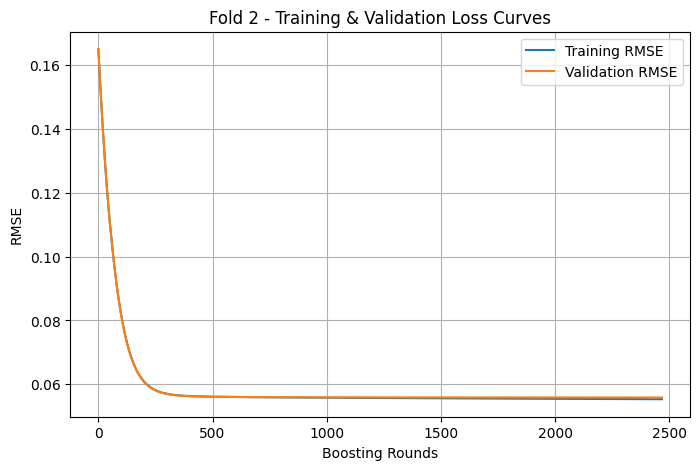

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822288	valid_1's rmse: 0.0822056
[200]	training's rmse: 0.0609181	valid_1's rmse: 0.0608767
[300]	training's rmse: 0.0570308	valid_1's rmse: 0.0570282
[400]	training's rmse: 0.0563019	valid_1's rmse: 0.0563433
[500]	training's rmse: 0.0561004	valid_1's rmse: 0.0561826
[600]	training's rmse: 0.0559994	valid_1's rmse: 0.0561187
[700]	training's rmse: 0.0559311	valid_1's rmse: 0.0560884
[800]	training's rmse: 0.0558757	valid_1's rmse: 0.0560692
[900]	training's rmse: 0.0558261	valid_1's rmse: 0.0560558
[1000]	training's rmse: 0.055783	valid_1's rmse: 0.0560465
[1100]	training's rmse: 0.0557418	valid_1's rmse: 0.0560399
[1200]	training's rmse: 0.0557028	valid_1's rmse: 0.0560332
[1300]	training's rmse: 0.0556662	valid_1's rmse: 0.0560277
[1400]	training's rmse: 0.0556317	valid_1's rmse: 0.0560245
[1500]	training's rmse: 0.0555984	valid_1's rmse: 0.0560206
[1600]	training's rmse: 0.0555654	valid_1's rmse

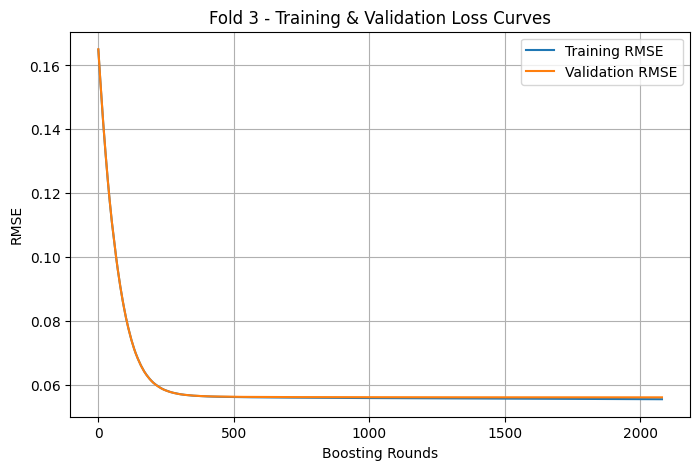

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822306	valid_1's rmse: 0.0822801
[200]	training's rmse: 0.0609061	valid_1's rmse: 0.0609787
[300]	training's rmse: 0.0570201	valid_1's rmse: 0.0571207
[400]	training's rmse: 0.0562904	valid_1's rmse: 0.0564299
[500]	training's rmse: 0.0560884	valid_1's rmse: 0.0562654
[600]	training's rmse: 0.0559868	valid_1's rmse: 0.0562039
[700]	training's rmse: 0.0559154	valid_1's rmse: 0.0561709
[800]	training's rmse: 0.0558608	valid_1's rmse: 0.0561536
[900]	training's rmse: 0.0558124	valid_1's rmse: 0.0561407
[1000]	training's rmse: 0.0557681	valid_1's rmse: 0.0561293
[1100]	training's rmse: 0.0557273	valid_1's rmse: 0.0561212
[1200]	training's rmse: 0.0556896	valid_1's rmse: 0.0561147
[1300]	training's rmse: 0.0556529	valid_1's rmse: 0.0561107
[1400]	training's rmse: 0.0556171	valid_1's rmse: 0.0561079
[1500]	training's rmse: 0.0555836	valid_1's rmse: 0.0561053
[1600]	training's rmse: 0.0555513	valid_1's rms

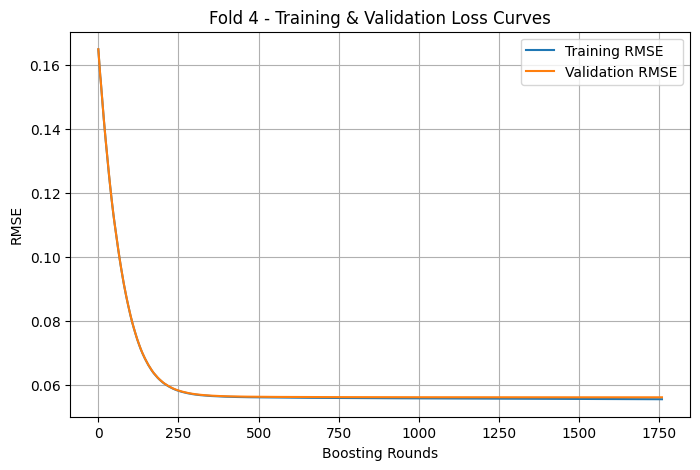

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822285	valid_1's rmse: 0.0821624
[200]	training's rmse: 0.0609046	valid_1's rmse: 0.0609469
[300]	training's rmse: 0.0570159	valid_1's rmse: 0.0571233
[400]	training's rmse: 0.0562876	valid_1's rmse: 0.0564373
[500]	training's rmse: 0.0560864	valid_1's rmse: 0.0562794
[600]	training's rmse: 0.0559868	valid_1's rmse: 0.0562189
[700]	training's rmse: 0.0559166	valid_1's rmse: 0.0561879
[800]	training's rmse: 0.0558622	valid_1's rmse: 0.056171
[900]	training's rmse: 0.0558146	valid_1's rmse: 0.0561561
[1000]	training's rmse: 0.0557712	valid_1's rmse: 0.0561466
[1100]	training's rmse: 0.0557307	valid_1's rmse: 0.0561376
[1200]	training's rmse: 0.055692	valid_1's rmse: 0.0561288
[1300]	training's rmse: 0.055655	valid_1's rmse: 0.0561206
[1400]	training's rmse: 0.0556203	valid_1's rmse: 0.056116
[1500]	training's rmse: 0.055587	valid_1's rmse: 0.0561126
[1600]	training's rmse: 0.0555547	valid_1's rmse: 0.

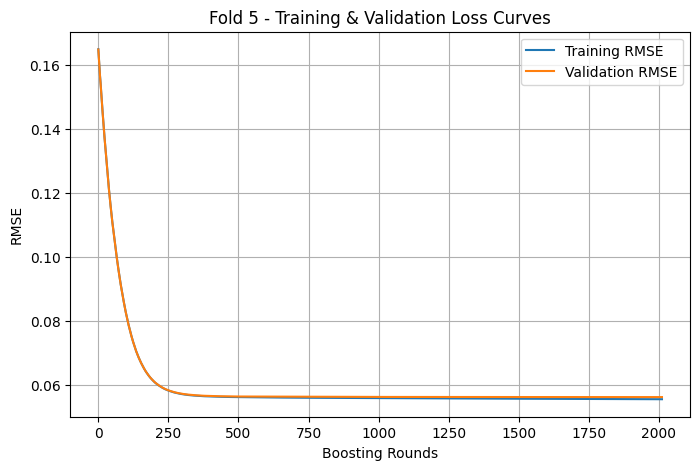

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0821941	valid_1's rmse: 0.0825854
[200]	training's rmse: 0.060853	valid_1's rmse: 0.0614736
[300]	training's rmse: 0.0569581	valid_1's rmse: 0.057648
[400]	training's rmse: 0.0562312	valid_1's rmse: 0.0569582
[500]	training's rmse: 0.0560299	valid_1's rmse: 0.0567881
[600]	training's rmse: 0.0559289	valid_1's rmse: 0.05672
[700]	training's rmse: 0.0558589	valid_1's rmse: 0.0566835
[800]	training's rmse: 0.0558035	valid_1's rmse: 0.056661
[900]	training's rmse: 0.0557553	valid_1's rmse: 0.0566458
[1000]	training's rmse: 0.0557116	valid_1's rmse: 0.0566338
[1100]	training's rmse: 0.0556719	valid_1's rmse: 0.0566253
[1200]	training's rmse: 0.0556341	valid_1's rmse: 0.0566185
[1300]	training's rmse: 0.0555983	valid_1's rmse: 0.0566162
[1400]	training's rmse: 0.0555633	valid_1's rmse: 0.0566131
[1500]	training's rmse: 0.0555302	valid_1's rmse: 0.0566095
[1600]	training's rmse: 0.0554979	valid_1's rmse: 0.

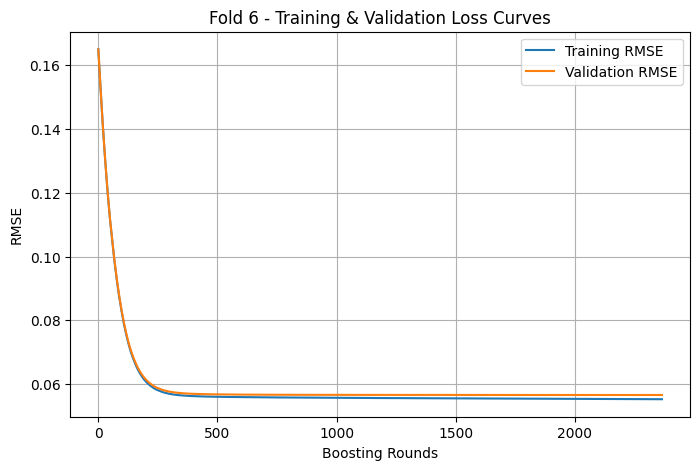

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822442	valid_1's rmse: 0.0822199
[200]	training's rmse: 0.0609327	valid_1's rmse: 0.0608206
[300]	training's rmse: 0.0570468	valid_1's rmse: 0.0569035
[400]	training's rmse: 0.0563175	valid_1's rmse: 0.0561924
[500]	training's rmse: 0.0561156	valid_1's rmse: 0.05602
[600]	training's rmse: 0.0560148	valid_1's rmse: 0.0559538
[700]	training's rmse: 0.0559452	valid_1's rmse: 0.055922
[800]	training's rmse: 0.0558882	valid_1's rmse: 0.0559011
[900]	training's rmse: 0.0558389	valid_1's rmse: 0.0558874
[1000]	training's rmse: 0.0557953	valid_1's rmse: 0.0558752
[1100]	training's rmse: 0.0557544	valid_1's rmse: 0.0558669
[1200]	training's rmse: 0.0557167	valid_1's rmse: 0.0558609
[1300]	training's rmse: 0.0556809	valid_1's rmse: 0.0558557
[1400]	training's rmse: 0.0556461	valid_1's rmse: 0.0558509
[1500]	training's rmse: 0.0556125	valid_1's rmse: 0.0558481
[1600]	training's rmse: 0.0555795	valid_1's rmse: 

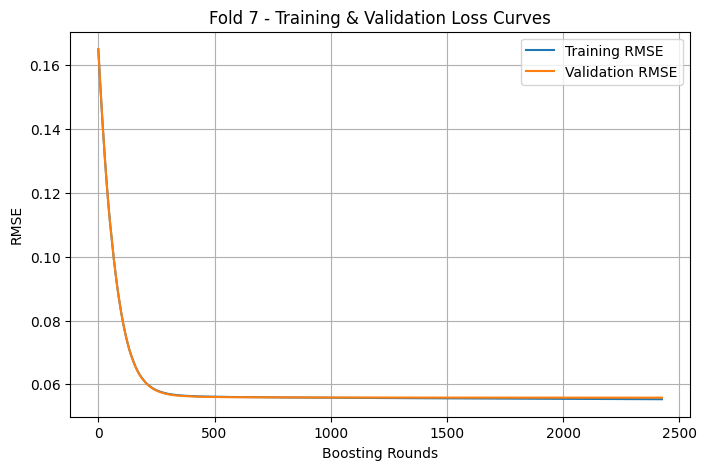

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822352	valid_1's rmse: 0.0823656
[200]	training's rmse: 0.0609071	valid_1's rmse: 0.061028
[300]	training's rmse: 0.0570223	valid_1's rmse: 0.0571304
[400]	training's rmse: 0.0562956	valid_1's rmse: 0.0564167
[500]	training's rmse: 0.0560934	valid_1's rmse: 0.0562398
[600]	training's rmse: 0.0559923	valid_1's rmse: 0.0561709
[700]	training's rmse: 0.055922	valid_1's rmse: 0.0561359
[800]	training's rmse: 0.0558662	valid_1's rmse: 0.0561142
[900]	training's rmse: 0.0558173	valid_1's rmse: 0.0560989
[1000]	training's rmse: 0.0557728	valid_1's rmse: 0.0560856
[1100]	training's rmse: 0.0557319	valid_1's rmse: 0.0560762
[1200]	training's rmse: 0.0556942	valid_1's rmse: 0.0560683
[1300]	training's rmse: 0.0556573	valid_1's rmse: 0.0560631
[1400]	training's rmse: 0.0556223	valid_1's rmse: 0.0560593
[1500]	training's rmse: 0.0555888	valid_1's rmse: 0.0560552
[1600]	training's rmse: 0.0555566	valid_1's rmse:

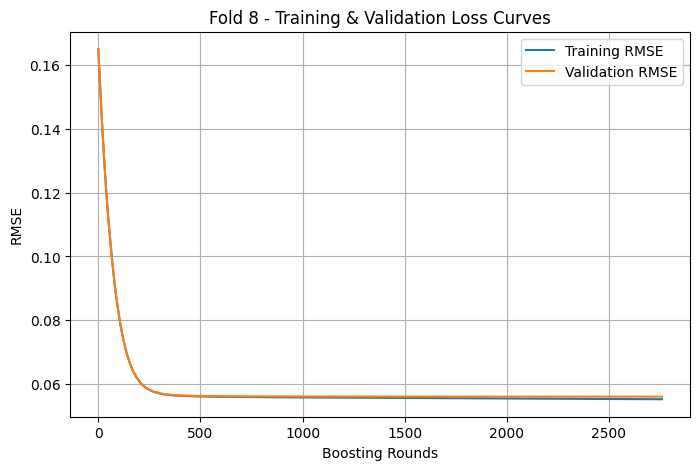

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822607	valid_1's rmse: 0.0820136
[200]	training's rmse: 0.0609526	valid_1's rmse: 0.0605957
[300]	training's rmse: 0.0570643	valid_1's rmse: 0.0567034
[400]	training's rmse: 0.0563349	valid_1's rmse: 0.0560032
[500]	training's rmse: 0.0561314	valid_1's rmse: 0.0558344
[600]	training's rmse: 0.0560296	valid_1's rmse: 0.0557683
[700]	training's rmse: 0.0559578	valid_1's rmse: 0.0557337
[800]	training's rmse: 0.0559018	valid_1's rmse: 0.0557141
[900]	training's rmse: 0.0558529	valid_1's rmse: 0.0556995
[1000]	training's rmse: 0.0558096	valid_1's rmse: 0.0556871
[1100]	training's rmse: 0.0557693	valid_1's rmse: 0.0556789
[1200]	training's rmse: 0.0557314	valid_1's rmse: 0.0556728
[1300]	training's rmse: 0.0556944	valid_1's rmse: 0.055668
[1400]	training's rmse: 0.0556599	valid_1's rmse: 0.0556646
[1500]	training's rmse: 0.0556257	valid_1's rmse: 0.0556611
[1600]	training's rmse: 0.0555929	valid_1's rmse

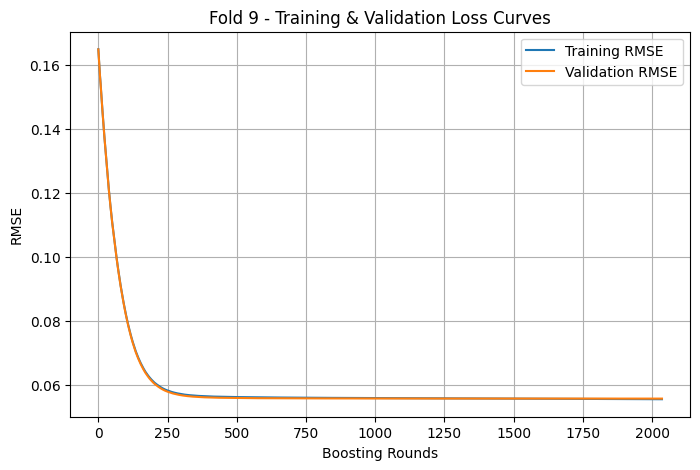

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0822107	valid_1's rmse: 0.0825438
[200]	training's rmse: 0.0608765	valid_1's rmse: 0.0613412
[300]	training's rmse: 0.0569831	valid_1's rmse: 0.0574779
[400]	training's rmse: 0.0562558	valid_1's rmse: 0.0567671
[500]	training's rmse: 0.0560534	valid_1's rmse: 0.0565919
[600]	training's rmse: 0.0559519	valid_1's rmse: 0.0565221
[700]	training's rmse: 0.0558832	valid_1's rmse: 0.0564887
[800]	training's rmse: 0.0558284	valid_1's rmse: 0.0564691
[900]	training's rmse: 0.05578	valid_1's rmse: 0.0564567
[1000]	training's rmse: 0.055735	valid_1's rmse: 0.0564457
[1100]	training's rmse: 0.0556947	valid_1's rmse: 0.0564404
[1200]	training's rmse: 0.0556566	valid_1's rmse: 0.0564349
[1300]	training's rmse: 0.0556196	valid_1's rmse: 0.056429
[1400]	training's rmse: 0.0555849	valid_1's rmse: 0.056424
[1500]	training's rmse: 0.0555504	valid_1's rmse: 0.0564206
[1600]	training's rmse: 0.0555172	valid_1's rmse: 0.

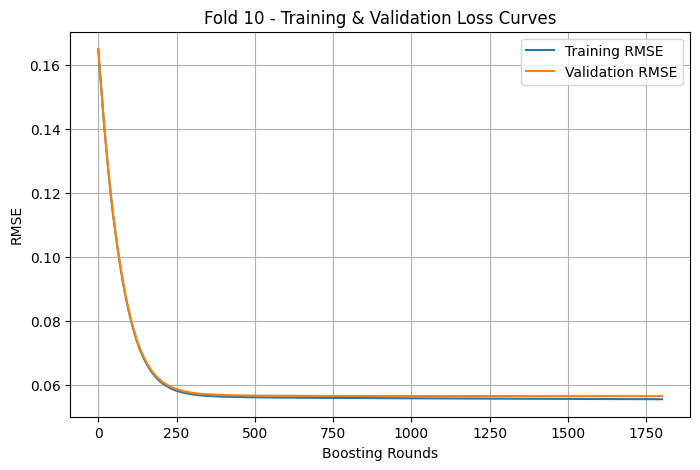


Overall CV RMSE: 0.05603791304705714
Average best iteration across all folds: 2058



In [48]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np

# Apply Advanced Feature Engineering
train_df_featured = feature_engineer(training_df)

# Apply to test data
print("Performing feature engineering on the test set...")
test_df_featured = feature_engineer(test_df, drop_duplicates = False)

# Prepare DataFrames for the Loop
y = train_df_featured['accident_risk']
X = train_df_featured.drop(columns=['id', 'accident_risk'], errors='ignore')

# These parameters are tuned for higher accuracy. They create a more complex model
# that learns more slowly, relying on early stopping to prevent overfitting.
lgb_params_tuned = {
    'objective': 'rmse',
    'metric': 'rmse',
    'n_estimators': 10000,          # Increased estimators
    'learning_rate': 0.01,         # Reduced learning rate
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 60,              # Increased leaves for more complex trees
    'verbose': -1,
    'n_jobs': -1,
    'seed': seed,
    'boosting_type': 'gbdt',
}

# Bin the continuous target variable for stratification
# This creates groups or "strata" that StratifiedKFold can use.
num_bins = int(np.floor(1 + np.log2(len(y))))
y_binned = pd.cut(y, bins = num_bins, labels = False)

# K-Fold Cross-Validation Training
NFOLDS = 10
folds = StratifiedKFold(n_splits = NFOLDS, shuffle = True, random_state = seed)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test_df_featured.shape[0])
best_iterations = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y_binned)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    # Initialize and train the model
    model = lgb.LGBMRegressor(**lgb_params_tuned)
    
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              eval_metric='rmse',
              callbacks = [
                  # Print evaluation results every 100 rounds
                  lgb.log_evaluation(period = 100),
                  # Stop if validation score doesn't improve for 100 rounds
                  lgb.early_stopping(100, verbose = True)
              ]
    )

    # Store best iteration for this fold
    best_iterations.append(model.best_iteration_)
    
    # Store Out-of-Fold (OOF) predictions
    oof_preds[valid_idx] = model.predict(X_valid)
    
    # Align columns
    train_columns = X_train.columns
    test_df_aligned = test_df_featured.reindex(columns = train_columns, fill_value = 0)

    # Add predictions to submission array (average over folds)
    sub_preds += model.predict(test_df_aligned) / folds.n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
    print(f"Fold {n_fold + 1} RMSE: {fold_rmse:.6f}")
    print(f"  -> Best Iteration: {model.best_iteration_}")
    
    # Plot Loss Curve for the Current Fold
    results = model.evals_result_
    
    plt.figure(figsize=(8, 5))
    plt.plot(results['training']['rmse'], label='Training RMSE')
    plt.plot(results['valid_1']['rmse'], label='Validation RMSE')
    plt.title(f'Fold {n_fold + 1} - Training & Validation Loss Curves')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the average best iteration and use it as the number of estimators
optimal_estimators = int(np.mean(best_iterations))
overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))

print("\n" + "="*40)
print(f"Overall CV RMSE: {overall_rmse}")
print(f"Average best iteration across all folds: {optimal_estimators}")
print("="*40 + "\n")

In [49]:
# Update the parameters for the final model
final_model_params = lgb_params_tuned.copy()
final_model_params['n_estimators'] = optimal_estimators

# Train the Final Model
print("Training the final model on the entire dataset...")

final_model = lgb.LGBMRegressor(**final_model_params)

# Fit the model on ALL of your training data (X and y).
# Apply Advanced Feature Engineering
train_df_featured = feature_engineer(training_df)

# Define features (X) and target (y)
y = train_df_featured['accident_risk'].copy()
X = train_df_featured.drop(columns=['id', 'accident_risk'], errors='ignore')

# No early stopping is needed here because we've already found the optimal number of trees.
final_model.fit(X, y, 
                eval_set = [(X, y)],
                categorical_feature = categorical_features,
                eval_metric='rmse',
                callbacks = [
                    # Print evaluation results every 100 rounds
                    lgb.log_evaluation(period = 100),
                ]
)

print("Final model training complete.")

Training the final model on the entire dataset...
[100]	training's rmse: 0.0822318
[200]	training's rmse: 0.0609133
[300]	training's rmse: 0.0570259
[400]	training's rmse: 0.056299
[500]	training's rmse: 0.0561023
[600]	training's rmse: 0.0560028
[700]	training's rmse: 0.0559352
[800]	training's rmse: 0.0558807
[900]	training's rmse: 0.0558358
[1000]	training's rmse: 0.0557952
[1100]	training's rmse: 0.0557573
[1200]	training's rmse: 0.0557212
[1300]	training's rmse: 0.0556865
[1400]	training's rmse: 0.0556545
[1500]	training's rmse: 0.0556231
[1600]	training's rmse: 0.0555931
[1700]	training's rmse: 0.0555635
[1800]	training's rmse: 0.0555354
[1900]	training's rmse: 0.0555069
[2000]	training's rmse: 0.0554795
Final model training complete.


In [50]:
print("Calculating score on original dataset")

original_df_featured = feature_engineer(original_df)

# Prepare DataFrames for the the prediction
y = original_df_featured['accident_risk']
X = original_df_featured.drop(columns=['id', 'accident_risk'], errors='ignore')

# Get the predictions
y_preds = final_model.predict(X)

original_rmse = np.sqrt(mean_squared_error(y, y_preds))
print(f"Original Dataset CV RMSE: {original_rmse}")

Calculating score on original dataset
Original Dataset CV RMSE: 0.08537832387771087


## Prepare Submission

In [51]:
print("Preparing the submission")

# Ready the data for prediction
X_test = X_test.drop(columns=[TARGET, "id"], errors="ignore")

# Convert categorical columns to the 'category' dtype for LightGBM
for col in categorical_features:
    X_test[col] = X_test[col].astype('category')
    
# Generate the predictions
test_preds = final_model.predict(X_test)

# Add back the IDs and write to CSV
submission = pd.DataFrame({"id": test_ids, "y": test_preds})
display(submission.head())

submission.to_csv("submission.csv", index = False)
print("Saved submission.csv")

Preparing the submission


id     y
0  517754 0.293
1  517755 0.123
2  517756 0.182
3  517757 0.317
4  517758 0.403

Saved submission.csv
